# **PREPARATION**

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Install the additional libraries
!pip install xgboost==1.7.6 scikit-learn==1.2.2
!pip install shap
!pip install permetrics

In [ ]:
# Import the libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import shap
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from permetrics.regression import RegressionMetric

# **EXPLORATORY DATA ANALYSIS**

In [ ]:
# Import the dataset
dataset = pd.read_csv('/content/drive/MyDrive/Research/Regression Analysis - Qult/Dataset/Dataset_q.csv')
dataset.head()

,beta,B,Df,phi,gamma,P,C,Q_ult
0,10,0.5,0.5,10,17,50,7.5,45.669
1,10,0.5,0.5,10,17,75,7.5,57.586
2,10,0.5,0.5,10,17,100,7.5,62.360
3,10,1.0,0.5,10,17,50,7.5,51.589
4,10,1.0,1.0,10,17,50,7.5,59.305


In [ ]:
# Get the information about each columns in the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   beta    1439 non-null   int64  
 1   B       1439 non-null   float64
 2   Df      1439 non-null   float64
 3   phi     1439 non-null   int64  
 4   gamma   1439 non-null   int64  
 5   P       1439 non-null   int64  
 6   C       1439 non-null   float64
 7   Q_ult   1379 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 90.1 KB


There is some rows that contain null-values in the Q_ult column, so we have to drop those.

In [ ]:
# Drop the rows in the dataset that contains null-value
dataset.dropna(subset=['Q_ult'], inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1379 entries, 0 to 1438
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   beta    1379 non-null   int64  
 1   B       1379 non-null   float64
 2   Df      1379 non-null   float64
 3   phi     1379 non-null   int64  
 4   gamma   1379 non-null   int64  
 5   P       1379 non-null   int64  
 6   C       1379 non-null   float64
 7   Q_ult   1379 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 97.0 KB


In [ ]:
# Describing the statistics of the dataset
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
beta,1379.0,24.358231,10.965940,10.000,10.0000,20.000,30.000,40.0
B,1379.0,1.499637,0.500181,0.500,1.0000,1.500,2.000,2.0
Df,1379.0,0.999275,0.499636,0.500,0.5000,1.000,1.500,2.0
phi,1379.0,17.820885,5.482970,10.000,15.0000,20.000,25.000,25.0
gamma,1379.0,18.955040,1.641536,17.000,17.0000,19.000,21.000,21.0
P,1379.0,74.981871,20.416109,50.000,50.0000,75.000,100.000,100.0
C,1379.0,7.500000,0.000000,7.500,7.5000,7.500,7.500,7.5
Q_ult,1379.0,900.559922,25024.232480,42.804,76.2685,136.788,307.526,929461.0


In [ ]:
# Delete duplicate rows based on specific columns (Features)
dataset = dataset.drop_duplicates(subset=["beta", "B", "Df", "phi", "gamma", "P"], keep=False)
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
beta,1379.0,24.358231,10.965940,10.000,10.0000,20.000,30.000,40.0
B,1379.0,1.499637,0.500181,0.500,1.0000,1.500,2.000,2.0
Df,1379.0,0.999275,0.499636,0.500,0.5000,1.000,1.500,2.0
phi,1379.0,17.820885,5.482970,10.000,15.0000,20.000,25.000,25.0
gamma,1379.0,18.955040,1.641536,17.000,17.0000,19.000,21.000,21.0
P,1379.0,74.981871,20.416109,50.000,50.0000,75.000,100.000,100.0
C,1379.0,7.500000,0.000000,7.500,7.5000,7.500,7.500,7.5
Q_ult,1379.0,900.559922,25024.232480,42.804,76.2685,136.788,307.526,929461.0


The 'C' column contains the same values in all of its rows, so we have to drop it.

In [ ]:
# Drop 'C' column from the dataset
dataset.drop('C', axis=1, inplace=True)
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
beta,1379.0,24.358231,10.965940,10.000,10.0000,20.000,30.000,40.0
B,1379.0,1.499637,0.500181,0.500,1.0000,1.500,2.000,2.0
Df,1379.0,0.999275,0.499636,0.500,0.5000,1.000,1.500,2.0
phi,1379.0,17.820885,5.482970,10.000,15.0000,20.000,25.000,25.0
gamma,1379.0,18.955040,1.641536,17.000,17.0000,19.000,21.000,21.0
P,1379.0,74.981871,20.416109,50.000,50.0000,75.000,100.000,100.0
Q_ult,1379.0,900.559922,25024.232480,42.804,76.2685,136.788,307.526,929461.0


The range between Q3 and the maximum point of the Q_ult is way too high, there must be some outliers in this dataset.

<Axes: ylabel='Q_ult'>

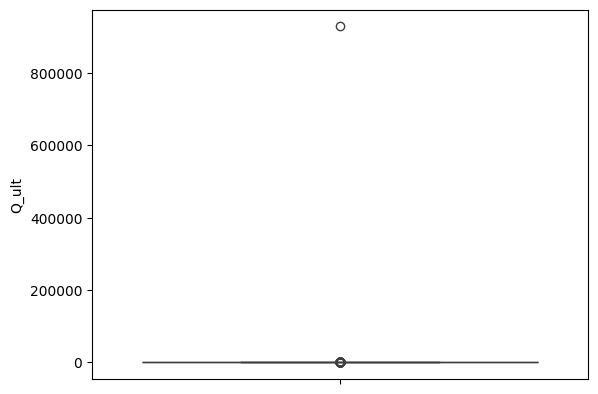

In [ ]:
# Detecting the outliers using boxplot
import seaborn as sns
sns.boxplot(dataset['Q_ult'])

As we see, there is some data that are actually way too far from the boxplot. We have to remove these data using the IQR point.

In [ ]:
# Print the old shape of the dataset
print("Old Shape: ", dataset.shape)

# IQR
# Calculate the upper and lower limits
Q1 = dataset['Q_ult'].quantile(0.25)
Q3 = dataset['Q_ult'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(dataset['Q_ult'] >= upper)[0]
lower_array = np.where(dataset['Q_ult'] <= lower)[0]

# Removing the outliers
dataset.drop(index=upper_array, inplace=True)
dataset.drop(index=lower_array, inplace=True)

# Print the new shape of the dataset
print("New Shape: ", dataset.shape)

Old Shape:  (1379, 7)
New Shape:  (1293, 7)


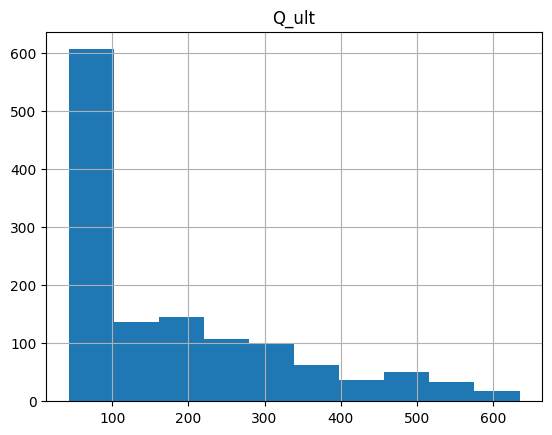

In [ ]:
# Show the histogram of the output variable
hist = dataset.hist(column='Q_ult')

The data is all clean, ready to go!

In [ ]:
# Save clean dataset into a csv file
dataset.to_csv('/content/drive/MyDrive/Research/Regression Analysis - Qult/Dataset/clean_dataset.csv', index=False)

## **Boxplot**

### Features

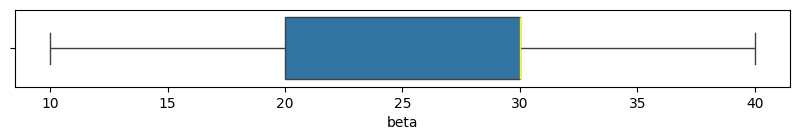

In [ ]:
# Show the horizontal boxplot of 'beta'
plt.figure(figsize=(10,1))
ax = sns.boxplot(data=dataset['beta'], orient="h", medianprops=dict(color="yellow", alpha=1))

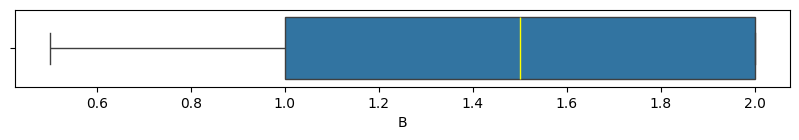

In [ ]:
# Show the horizontal boxplot of 'B'
plt.figure(figsize=(10,1))
ax = sns.boxplot(data=dataset['B'], orient="h", medianprops=dict(color="yellow", alpha=1))

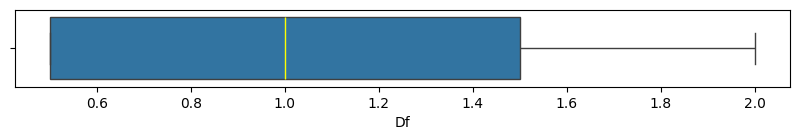

In [ ]:
# Show the horizontal boxplot of 'Df'
plt.figure(figsize=(10,1))
ax = sns.boxplot(data=dataset['Df'], orient="h", medianprops=dict(color="yellow", alpha=1))

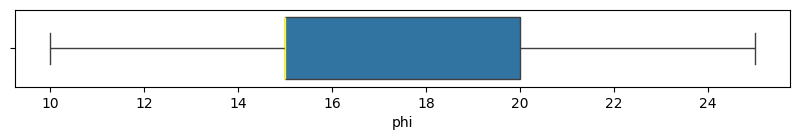

In [ ]:
# Show the horizontal boxplot of 'phi'
plt.figure(figsize=(10,1))
ax = sns.boxplot(data=dataset['phi'], orient="h", medianprops=dict(color="yellow", alpha=1))

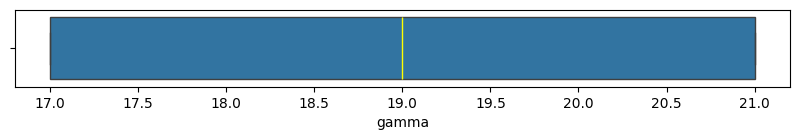

In [ ]:
# Show the horizontal boxplot of 'gamma'
plt.figure(figsize=(10,1))
ax = sns.boxplot(data=dataset['gamma'], orient="h", medianprops=dict(color="yellow", alpha=1))

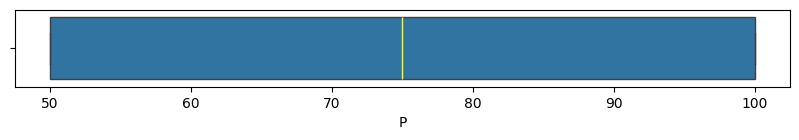

In [ ]:
# Show the horizontal boxplot of 'P'
plt.figure(figsize=(10,1))
ax = sns.boxplot(data=dataset['P'], orient="h", medianprops=dict(color="yellow", alpha=1))

# **DATA PREPROCESSING**

<Axes: >

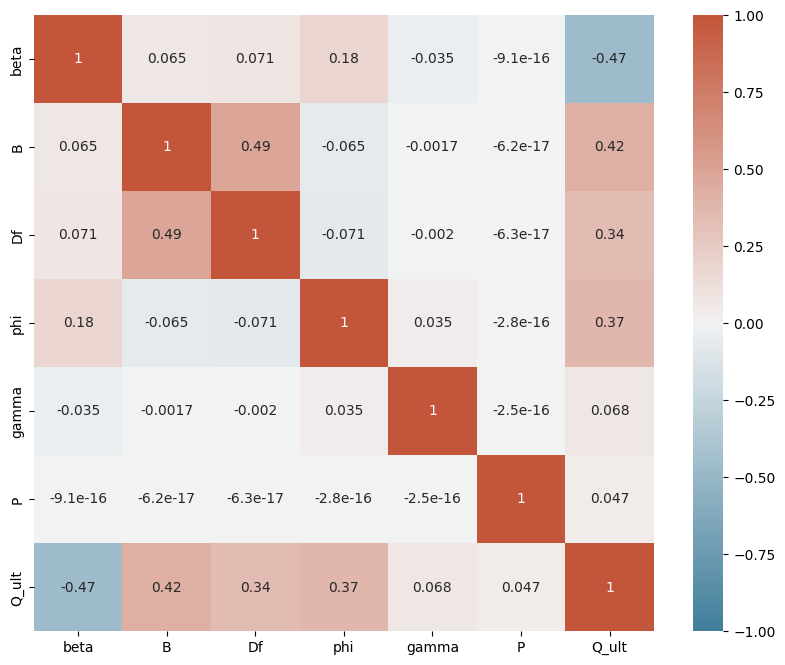

In [ ]:
# Show the correlations between each column
plt.figure(figsize=(10,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(dataset.corr(), cmap=cmap, vmin=-1, vmax=1, annot=True)

In [ ]:
# Defining input and output variables
X = dataset[['beta','B','Df','phi','gamma','P']]
y = dataset['Q_ult']

In [ ]:
# Splitting the data into training and testing sets with an 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show the amount of data in training and test set
print(f"X_train rows: {len(X_train)}")
print(f"X_test rows: {len(X_test)}")
print(f"y_train rows: {len(y_train)}")
print(f"y_test rows: {len(y_test)}")

X_train rows: 1034
X_test rows: 259
y_train rows: 1034
y_test rows: 259


In [ ]:
# Make a dataframe that includes X_train and y_train
train_data = pd.concat([X_train, y_train], axis=1)
print(len(train_data))

# Save it into a csv file
train_data.to_csv('/content/drive/MyDrive/Research/Regression Analysis - Qult/Dataset/train_data.csv', index=False)

1034


In [ ]:
# Make a dataframe that includes X_train and y_train
test_data = pd.concat([X_test, y_test], axis=1)
print(len(test_data))

# Save it into a csv file
test_data.to_csv('/content/drive/MyDrive/Research/Regression Analysis - Qult/Dataset/test_data.csv', index=False)

259


# **MODELING**

### **1. Multiple Linear Regression**

In [ ]:
# Creating and training the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Apply k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr_rmse_scores = []
lr_r2_scores = []
lr_mape_scores = []
lr_a20_index_scores = []
lr_a30_index_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    lr_model.fit(X_train_fold, y_train_fold)
    lr_y_val_pred = lr_model.predict(X_val_fold)

    kf_lr_mse = mean_squared_error(y_val_fold, lr_y_val_pred)
    kf_lr_rmse = math.sqrt(kf_lr_mse)
    lr_rmse_scores.append(kf_lr_rmse)

    kf_lr_r2 = r2_score(y_val_fold, lr_y_val_pred)
    lr_r2_scores.append(kf_lr_r2)

    kf_lr_mape = mean_absolute_percentage_error(y_val_fold, lr_y_val_pred)
    lr_mape_scores.append(kf_lr_mape)

    kf_lr_evaluator = RegressionMetric(np.array(y_val_fold), np.array(lr_y_val_pred))
    lr_a20_index_scores.append(kf_lr_evaluator.a20_index())

    kf_lr_evaluator = RegressionMetric(np.array(y_val_fold), np.array(lr_y_val_pred))
    lr_a30_index_scores.append(kf_lr_evaluator.a30_index())

print(f"RMSE: {lr_rmse_scores}")
print(f"R-Sq: {lr_r2_scores}")
print(f"MAPE: {lr_mape_scores}")
print(f"A20: {lr_a20_index_scores}")
print(f"A30: {lr_a30_index_scores}")


RMSE: [74.5533143689959, 73.84676791577724, 78.14761812711657, 76.85082208536235, 78.52485420988606]
R-Sq: [0.698747666633081, 0.750380980269994, 0.7130806565279111, 0.7122857522744753, 0.7068179526364367]
MAPE: [0.5687114130368484, 0.512141188614118, 0.5590769804123845, 0.5421752545902926, 0.6101636402941227]
A20: [0.3719806763285024, 0.3285024154589372, 0.3719806763285024, 0.36231884057971014, 0.3592233009708738]
A30: [0.5314009661835749, 0.5265700483091788, 0.5314009661835749, 0.5072463768115942, 0.4854368932038835]


In [ ]:
# Predict using train set
lr_train_pred = lr_model.predict(X_train)

# Evaluate the model (rmse, r2 score, mape, a20 and a30 index)
lr_train_mse = mean_squared_error(y_train, lr_train_pred)
lr_train_rmse = math.sqrt(lr_train_mse)
lr_train_r2 = r2_score(y_train, lr_train_pred)
lr_train_mape = mean_absolute_percentage_error(y_train, lr_train_pred)
lr_train_a20_index = RegressionMetric(np.array(y_train), np.array(lr_train_pred)).a20_index()
lr_train_a30_index = RegressionMetric(np.array(y_train), np.array(lr_train_pred)).a30_index()

print(f"RMSE: {lr_train_rmse}")
print(f"R-squared Score: {lr_model.score(X_train, y_train)}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, lr_train_pred)}")
print(f"A20: {lr_train_a20_index}")
print(f"A30: {lr_train_a30_index}")

RMSE: 75.73955936574392
R-squared Score: 0.7221809074519425
MAPE: 0.5533471174423
A20: 0.35589941972920697
A30: 0.5299806576402321


In [ ]:
# Making predictions on the test set
lr_y_pred = lr_model.predict(X_test)

# Evaluating the model
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_rmse = math.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_y_pred)
lr_mape = mean_absolute_percentage_error(y_test, lr_y_pred)
lr_a20_index = RegressionMetric(np.array(y_test), np.array(lr_y_pred)).a20_index()
lr_a30_index = RegressionMetric(np.array(y_test), np.array(lr_y_pred)).a30_index()

print(f"RMSE: {lr_rmse}")
print(f"R-squared Score: {lr_r2}")
print(f"MAPE: {lr_mape}")
print(f"A20: {lr_a20_index}")
print(f"A20: {lr_a30_index}")

RMSE: 72.81276827665724
R-squared Score: 0.748377553098283
MAPE: 0.5303979946073322
A20: 0.3667953667953668
A20: 0.5444015444015444


In [ ]:
# Getting the mathematical equation of the model
intercept = lr_model.intercept_
coefficients = lr_model.coef_

# Print the equation
print("Intercept (β0):", intercept)
print("Coefficients (β1, β2, β3, β4, β5, β6):", coefficients)

# Form the equation as a string for easier reading
equation = f"y = {intercept}"
for i, coef in enumerate(coefficients):
    equation += f" + ({coef} * x{i+1})"

print("Equation of the model:")
print(equation)

Intercept (β0): -193.27889394024461
Coefficients (β1, β2, β3, β4, β5, β6): [ -8.16446832 104.36474038  69.82913203  13.9014137    4.90357584
   0.3426786 ]
Equation of the model:
y = -193.27889394024461 + (-8.164468319976546 * x1) + (104.36474038209121 * x2) + (69.82913202607118 * x3) + (13.901413704726352 * x4) + (4.903575836112809 * x5) + (0.34267860075682854 * x6)


### **2. Ridge Regression (α=0.001)**

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import math

# Define the Ridge model
r_model = Ridge()

# Define the hyperparameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Set up GridSearchCV with 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=r_model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV on the training set
grid_search.fit(X_train, y_train)

# Retrieve the best model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Evaluate the model using cross-validation with the optimal alpha
r_rmse_scores = []
r_r2_scores = []
r_mape_scores = []
r_a20_index_scores = []
r_a30_index_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model with the best alpha
    best_model.fit(X_train_fold, y_train_fold)
    r_y_val_pred = best_model.predict(X_val_fold)

    # Calculate evaluation metrics
    kf_r_mse = mean_squared_error(y_val_fold, r_y_val_pred)
    kf_r_rmse = math.sqrt(kf_r_mse)
    r_rmse_scores.append(kf_r_rmse)

    kf_r_r2 = r2_score(y_val_fold, r_y_val_pred)
    r_r2_scores.append(kf_r_r2)

    kf_r_mape = mean_absolute_percentage_error(y_val_fold, r_y_val_pred)
    r_mape_scores.append(kf_r_mape)

    kf_r_evaluator = RegressionMetric(np.array(y_val_fold), np.array(r_y_val_pred))
    r_a20_index_scores.append(kf_r_evaluator.a20_index())
    r_a30_index_scores.append(kf_r_evaluator.a30_index())

# Print cross-validation results
print(f"RMSE: {r_rmse_scores}")
print(f"R-Sq: {r_r2_scores}")
print(f"MAPE: {r_mape_scores}")
print(f"A20: {r_a20_index_scores}")
print(f"A30: {r_a30_index_scores}")

# Final model metrics
print(f"Mean RMSE: {np.mean(r_rmse_scores):.4f}")
print(f"Mean R-Squared: {np.mean(r_r2_scores):.4f}")
print(f"Mean MAPE: {np.mean(r_mape_scores):.4f}")
print(f"Mean A20 Index: {np.mean(r_a20_index_scores):.4f}")
print(f"Mean A30 Index: {np.mean(r_a30_index_scores):.4f}")


Best Hyperparameters: {'alpha': 0.1}
RMSE: [74.5514230162256, 73.84620735098241, 78.14836912456529, 76.84971354495039, 78.5274936975881]
R-Sq: [0.6987629514587861, 0.7503847699308671, 0.7130751419201609, 0.7122940525258388, 0.7067982426115755]
MAPE: [0.5686426025911119, 0.5120447524068664, 0.5590414161810223, 0.5420895556081224, 0.610146510811984]
A20: [0.3719806763285024, 0.3285024154589372, 0.3719806763285024, 0.36231884057971014, 0.3592233009708738]
A30: [0.5314009661835749, 0.5265700483091788, 0.5314009661835749, 0.5072463768115942, 0.4854368932038835]
Mean RMSE: 76.3846
Mean R-Squared: 0.7163
Mean MAPE: 0.5584
Mean A20 Index: 0.3588
Mean A30 Index: 0.5164


In [ ]:
# Apply k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r_rmse_scores = []
r_r2_scores = []
r_mape_scores = []
r_a20_index_scores = []
r_a30_index_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    r_model.fit(X_train_fold, y_train_fold)
    r_y_val_pred = r_model.predict(X_val_fold)

    kf_r_mse = mean_squared_error(y_val_fold, r_y_val_pred)
    kf_r_rmse = math.sqrt(kf_r_mse)
    r_rmse_scores.append(kf_r_rmse)

    kf_r_r2 = r2_score(y_val_fold, r_y_val_pred)
    r_r2_scores.append(kf_r_r2)

    kf_r_mape = mean_absolute_percentage_error(y_val_fold, r_y_val_pred)
    r_mape_scores.append(kf_lr_mape)

    kf_r_evaluator = RegressionMetric(np.array(y_val_fold), np.array(r_y_val_pred))
    r_a20_index_scores.append(kf_r_evaluator.a20_index())

    kf_r_evaluator = RegressionMetric(np.array(y_val_fold), np.array(r_y_val_pred))
    r_a30_index_scores.append(kf_r_evaluator.a30_index())

print(f"RMSE: {r_rmse_scores}")
print(f"R-Sq: {r_r2_scores}")
print(f"MAPE: {r_mape_scores}")
print(f"A20: {r_a20_index_scores}")
print(f"A30: {r_a30_index_scores}")

RMSE: [74.53485672031861, 73.84167246748787, 78.15553610650886, 76.8401868078721, 78.55156825247842]
R-Sq: [0.6988968141650497, 0.7504154266502899, 0.7130225117860829, 0.7123653795068291, 0.7066184384823463]
MAPE: [0.6101636402941227, 0.6101636402941227, 0.6101636402941227, 0.6101636402941227, 0.6101636402941227]
A20: [0.3719806763285024, 0.3285024154589372, 0.3719806763285024, 0.36231884057971014, 0.3592233009708738]
A30: [0.5314009661835749, 0.5265700483091788, 0.5314009661835749, 0.5072463768115942, 0.4854368932038835]


In [ ]:
# Predict using train set
r_train_pred = r_model.predict(X_train)

# Evaluate the model (rmse, r2 score, mape, a20 and a30 index)
r_train_mse = mean_squared_error(y_train, r_train_pred)
r_train_rmse = math.sqrt(r_train_mse)
r_train_r2 = r2_score(y_train, r_train_pred)
r_train_mape = mean_absolute_percentage_error(y_train, r_train_pred)
r_train_a20_index = RegressionMetric(np.array(y_train), np.array(r_train_pred)).a20_index()
r_train_a30_index = RegressionMetric(np.array(y_train), np.array(r_train_pred)).a30_index()

print(f"RMSE: {r_train_rmse}")
print(f"R-squared Score: {r_model.score(X_train, y_train)}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, r_train_pred)}")
print(f"A20: {r_train_a20_index}")
print(f"A30: {r_train_a30_index}")

RMSE: 75.74544414811942
R-squared Score: 0.7221377340184765
MAPE: 0.5528051159284644
A20: 0.3568665377176016
A30: 0.5290135396518375


In [ ]:
# Predict using train set
lr_train_pred = lr_model.predict(X_train)

# Evaluate the model (rmse, r2 score, mape, a20 and a30 index)
lr_train_mse = mean_squared_error(y_train, lr_train_pred)
lr_train_rmse = math.sqrt(lr_train_mse)
lr_train_r2 = r2_score(y_train, lr_train_pred)
lr_train_mape = mean_absolute_percentage_error(y_train, lr_train_pred)
lr_train_a20_index = RegressionMetric(np.array(y_train), np.array(lr_train_pred)).a20_index()
lr_train_a30_index = RegressionMetric(np.array(y_train), np.array(lr_train_pred)).a30_index()

print(f"RMSE: {lr_train_rmse}")
print(f"R-squared Score: {lr_model.score(X_train, y_train)}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, lr_train_pred)}")
print(f"A20: {lr_train_a20_index}")
print(f"A30: {lr_train_a30_index}")

RMSE: 75.73955936574392
R-squared Score: 0.7221809074519425
MAPE: 0.5533471174423
A20: 0.35589941972920697
A30: 0.5299806576402321


In [ ]:
# Making predictions on the test set
r_y_pred = r_model.predict(X_test)

In [ ]:
# Evaluating the model
r_mse = mean_squared_error(y_test, r_y_pred)
r_rmse = math.sqrt(r_mse)
r_r2 = r2_score(y_test, r_y_pred)
r_mape = mean_absolute_percentage_error(y_test, r_y_pred)
r_a20_index = RegressionMetric(np.array(y_test), np.array(r_y_pred)).a20_index()
r_a30_index = RegressionMetric(np.array(y_test), np.array(r_y_pred)).a30_index()

print(f"RMSE: {r_rmse}")
print(f"R-squared Score: {r_r2}")
print(f"MAPE: {r_mape}")
print(f"A20: {r_a20_index}")
print(f"A30: {r_a30_index}")

RMSE: 72.84020885910738
R-squared Score: 0.7481878619842802
MAPE: 0.5302430153750238
A20: 0.3667953667953668
A30: 0.5444015444015444


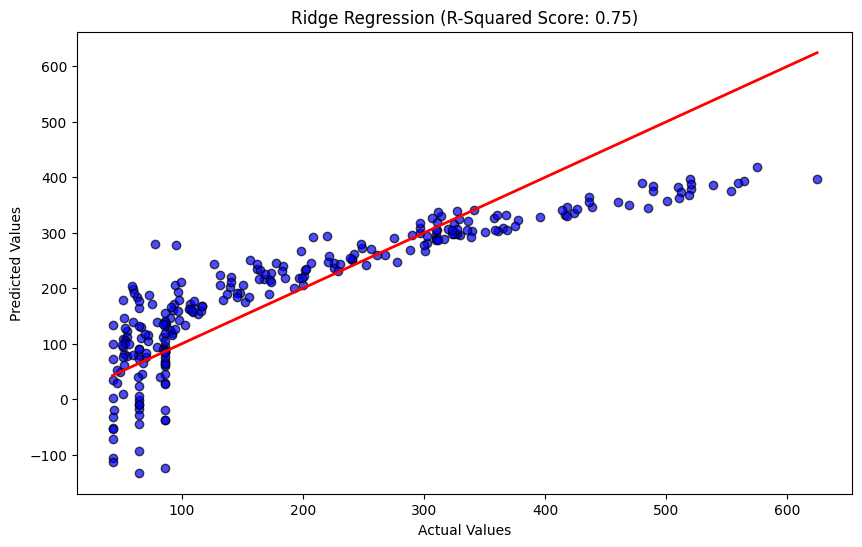

In [ ]:
# Show the scatter plot of the actual and predicted data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, r_y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Identity line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Ridge Regression (R-Squared Score: {:.2f})'.format(r_r2))
plt.show()

In [ ]:
# Get the coefficients and intercept
intercept = r_model.intercept_
coefficients = r_model.coef_

# Print the equation
print("Intercept (β0):", intercept)
print("Coefficients (β1, β2, β3, β4, β5, β6):", coefficients)

# Form the equation as a string for easier reading
equation = f"y = {intercept}"
for i, coef in enumerate(coefficients):
    equation += f" + ({coef} * x{i+1})"

print("Equation of the model:")
print(equation)

Intercept (β0): -192.4415536360285
Coefficients (β1, β2, β3, β4, β5, β6): [ -8.16198405 103.91784636  69.67351696  13.89795839   4.90176823
   0.34269474]
Equation of the model:
y = -192.4415536360285 + (-8.161984046594952 * x1) + (103.91784635729822 * x2) + (69.67351696097438 * x3) + (13.897958386651181 * x4) + (4.901768229216335 * x5) + (0.3426947368391065 * x6)


### **3. Lasso Regression (α=0.001)**

In [ ]:
# Creating and training the regression model
l_model = Lasso(alpha=0.001)
l_model.fit(X_train, y_train)

Lasso(alpha=0.001)

In [ ]:
# Apply k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
l_rmse_scores = []
l_r2_scores = []
l_mape_scores = []
l_a20_index_scores = []
l_a30_index_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    l_model.fit(X_train_fold, y_train_fold)
    l_y_val_pred = l_model.predict(X_val_fold)

    kf_l_mse = mean_squared_error(y_val_fold, l_y_val_pred)
    kf_l_rmse = math.sqrt(kf_l_mse)
    l_rmse_scores.append(kf_l_rmse)

    kf_l_r2 = r2_score(y_val_fold, l_y_val_pred)
    l_r2_scores.append(kf_l_r2)

    kf_l_mape = mean_absolute_percentage_error(y_val_fold, l_y_val_pred)
    l_mape_scores.append(kf_l_mape)

    kf_l_evaluator = RegressionMetric(np.array(y_val_fold), np.array(l_y_val_pred))
    l_a20_index_scores.append(kf_l_evaluator.a20_index())
    l_a30_index_scores.append(kf_l_evaluator.a30_index())

print(f"RMSE: {l_rmse_scores}")
print(f"R-Sq: {l_r2_scores}")
print(f"MAPE: {l_mape_scores}")
print(f"A20: {l_a20_index_scores}")
print(f"A30: {l_a30_index_scores}")

RMSE: [74.55321217945428, 73.84685538491317, 78.14768748715042, 76.85068996755703, 78.52493480488886]
R-Sq: [0.6987484924801148, 0.7503803889381452, 0.7130801472163112, 0.7122867415193855, 0.7068173508137325]
MAPE: [0.5687067272212072, 0.5121346328989145, 0.5590742630470451, 0.5421692601553538, 0.6101598790656468]
A20: [0.3719806763285024, 0.3285024154589372, 0.3719806763285024, 0.36231884057971014, 0.3592233009708738]
A30: [0.5314009661835749, 0.5265700483091788, 0.5314009661835749, 0.5072463768115942, 0.4854368932038835]


In [ ]:
# Predict using train set
l_train_pred = l_model.predict(X_train)

# Evaluate the model (rmse, r2 score, mape, a20 and a30 index)
l_train_mse = mean_squared_error(y_train, l_train_pred)
l_train_rmse = math.sqrt(l_train_mse)
l_train_r2 = r2_score(y_train, l_train_pred)
l_train_mape = mean_absolute_percentage_error(y_train, l_train_pred)
l_train_a20_index = RegressionMetric(np.array(y_train), np.array(l_train_pred)).a20_index()
l_train_a30_index = RegressionMetric(np.array(y_train), np.array(l_train_pred)).a30_index()

print(f"RMSE: {l_train_rmse}")
print(f"R-squared Score: {l_model.score(X_train, y_train)}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, l_train_pred)}")
print(f"A20: {l_train_a20_index}")
print(f"A30: {l_train_a30_index}")

RMSE: 75.73957604018601
R-squared Score: 0.7221807851254087
MAPE: 0.553342609674964
A20: 0.35589941972920697
A30: 0.5299806576402321


In [ ]:
# Making predictions on the test set
l_y_pred = l_model.predict(X_test)

In [ ]:
# Evaluating the model
l_mse = mean_squared_error(y_test, l_y_pred)
l_rmse = math.sqrt(l_mse)
l_r2 = r2_score(y_test, l_y_pred)
l_mape = mean_absolute_percentage_error(y_test, l_y_pred)
l_a20_index = RegressionMetric(np.array(y_test), np.array(l_y_pred)).a20_index()
l_a30_index = RegressionMetric(np.array(y_test), np.array(l_y_pred)).a30_index()

print(f"RMSE: {l_rmse}")
print(f"R-squared Score: {l_r2}")
print(f"MAPE: {l_mape}")
print(f"A20: {l_a20_index}")
print(f"A30: {l_a30_index}")

RMSE: 72.81287870817009
R-squared Score: 0.7483767898511436
MAPE: 0.5303953288371734
A20: 0.3667953667953668
A30: 0.5444015444015444


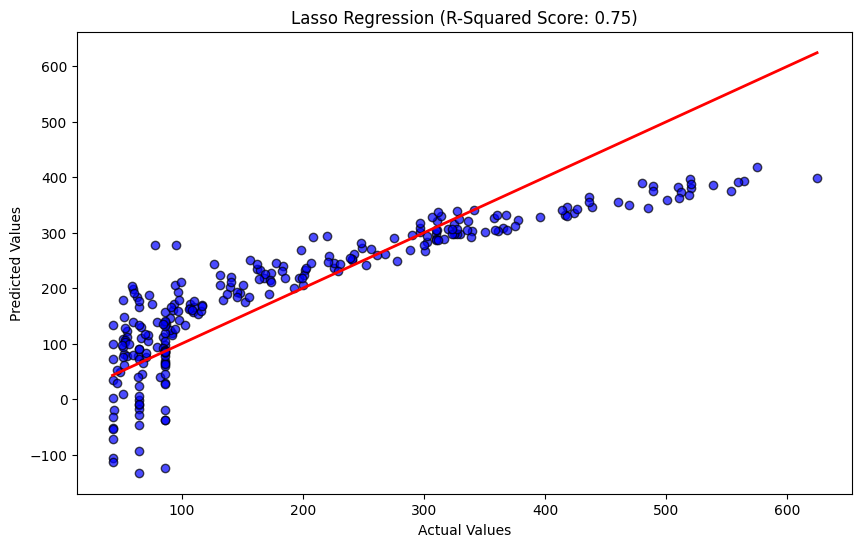

In [ ]:
# Show the scatter plot of the actual and predicted data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, l_y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Identity line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Lasso Regression (R-Squared Score: {:.2f})'.format(l_r2))
plt.show()

In [ ]:
# Get the coefficients and intercept
intercept = l_model.intercept_
coefficients = l_model.coef_

# Print the equation
print("Intercept (β0):", intercept)
print("Coefficients (β1, β2, β3, β4, β5, β6):", coefficients)

# Form the equation as a string for easier reading
equation = f"y = {intercept}"
for i, coef in enumerate(coefficients):
    equation += f" + ({coef} * x{i+1})"

print("Equation of the model:")
print(equation)

Intercept (β0): -193.2657049566744
Coefficients (β1, β2, β3, β4, β5, β6): [ -8.16444588 104.36340407  69.82536215  13.90134845   4.9032158
   0.34267565]
Equation of the model:
y = -193.2657049566744 + (-8.164445883102708 * x1) + (104.36340407396169 * x2) + (69.82536215497358 * x3) + (13.901348446936058 * x4) + (4.903215796817828 * x5) + (0.34267564502073494 * x6)


### **4. Polynomial Regression**

In [ ]:
# Input train data
train_data = pd.read_csv('/content/drive/MyDrive/Research/Regression Analysis - Qult/Dataset/train_data.csv')
# Set train data into X_train and y_train
X_train = train_data.drop('Q_ult', axis=1)
y_train = train_data['Q_ult']
# Input test data
test_data = pd.read_csv('/content/drive/MyDrive/Research/Regression Analysis - Qult/Dataset/test_data.csv')
# Set test data into X_test and y_test
X_test = test_data.drop('Q_ult', axis=1)
y_test = test_data['Q_ult']

In [ ]:
# Initialize polynomial feature transformer
from sklearn.preprocessing import PolynomialFeatures
degree = 2  # You can adjust the degree of the polynomial as needed
poly = PolynomialFeatures(degree=degree, include_bias=False)

# Transform features into polynomial features
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Initialize the regression model
p_model = LinearRegression()

In [ ]:
# Train the model on the training data
p_model.fit(X_train_poly, y_train)

# Make predictions on the test data
p_y_train_pred = p_model.predict(X_train_poly)

# Save result
p_train_result = pd.DataFrame({'Actual': y_train, 'Predicted': p_y_train_pred})
p_train_result

,Actual,Predicted
0,107.550,108.593912
1,58.649,88.092798
2,139.741,155.989281
3,198.265,184.673724
4,52.510,43.164828
...,...,...
1029,56.832,79.949485
1030,78.087,77.826815
1031,86.078,75.749314
1032,316.611,310.884466


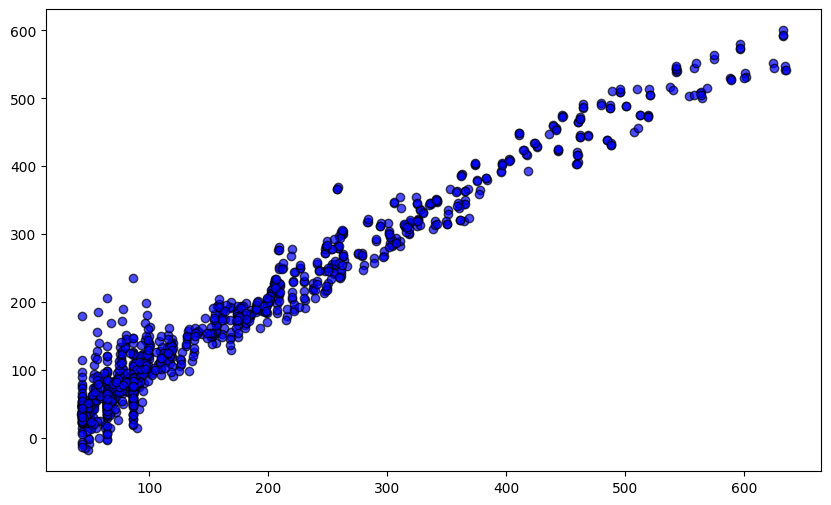

In [ ]:
# Show scatter plot that show actual vs predicted result
plt.figure(figsize=(10, 6))
plt.scatter(y_train, p_y_train_pred, color='blue', edgecolor='k', alpha=0.7)

In [ ]:
# Save dataframe to a csv file
p_train_result.to_csv('/content/drive/MyDrive/Research/Regression Analysis - Qult/Dataset/p_train_result.csv', index=False)

In [ ]:
# Train the model on the training data
model.fit(X_train_poly, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

In [ ]:
# Make a separate dataframe for this model
Xp = X
yp = y

# Create a polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(Xp)

# Splitting the data into training and testing sets with an 80:20 ratio
Xp_train, Xp_test, yp_train, yp_test = train_test_split(poly_features, yp, test_size=0.2, random_state=42)

In [ ]:
# Creating and training the regression model
p_model = LinearRegression()
p_model.fit(Xp_train, yp_train)

LinearRegression()

In [ ]:
# Apply k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
p_rmse_scores = []
p_r2_scores = []
p_mape_scores = []
p_a20_index_scores = []
p_a30_index_scores = []

for train_index, val_index in kf.split(Xp_train):
    Xp_train_fold, Xp_val_fold = Xp_train[train_index], Xp_train[val_index]
    yp_train_fold, yp_val_fold = yp_train.iloc[train_index], yp_train.iloc[val_index]

    p_model.fit(Xp_train_fold, yp_train_fold)
    p_yp_val_pred = p_model.predict(Xp_val_fold)

    kf_p_mse = mean_squared_error(yp_val_fold, p_yp_val_pred)
    kf_p_rmse = math.sqrt(kf_p_mse)
    p_rmse_scores.append(kf_p_rmse)

    kf_p_r2 = r2_score(yp_val_fold, p_yp_val_pred)
    p_r2_scores.append(kf_p_r2)

    kf_p_mape = mean_absolute_percentage_error(yp_val_fold, p_yp_val_pred)
    p_mape_scores.append(kf_p_mape)

    kf_p_evaluator = RegressionMetric(np.array(yp_val_fold), np.array(p_yp_val_pred))
    p_a20_index_scores.append(kf_p_evaluator.a20_index())
    p_a30_index_scores.append(kf_p_evaluator.a30_index())

print(f"RMSE: {p_rmse_scores}")
print(f"R-Sq: {p_r2_scores}")
print(f"MAPE: {p_mape_scores}")
print(f"A20: {p_a20_index_scores}")
print(f"A30: {p_a30_index_scores}")

RMSE: [27.168720279124642, 29.860392569390292, 31.732670387241715, 30.08313848123532, 29.63585262195936]
R-Sq: [0.9599931024935495, 0.9591863237480153, 0.9526912385330925, 0.9559129926698884, 0.9582402443731263]
MAPE: [0.16778223191039662, 0.21605312994010398, 0.2268389895607122, 0.20288236829034287, 0.20769186500715717]
A20: [0.7681159420289855, 0.6956521739130435, 0.7004830917874396, 0.7681159420289855, 0.6796116504854369]
A30: [0.8502415458937198, 0.782608695652174, 0.7681159420289855, 0.8405797101449275, 0.7669902912621359]


In [ ]:
# Making predictions on the test set
p_y_pred = p_model.predict(Xp_test)

# Evaluating the model
p_mse = mean_squared_error(yp_test, p_y_pred)
p_rmse = math.sqrt(p_mse)
p_r2 = r2_score(yp_test, p_y_pred)
p_mape = mean_absolute_percentage_error(yp_test, p_y_pred)
p_a20_index = RegressionMetric(np.array(yp_test), np.array(p_y_pred)).a20_index()
p_a30_index = RegressionMetric(np.array(yp_test), np.array(p_y_pred)).a30_index()

print(f"RMSE: {(p_rmse)}")
print(f"R-squared Score: {p_r2}")
print(f"MAPE: {p_mape}")
print(f"A20: {p_a20_index}")
print(f"A30: {p_a30_index}")

RMSE: 27.70139058142822
R-squared Score: 0.9635802100136339
MAPE: 0.1992822545707529
A20: 0.7142857142857143
A30: 0.7876447876447876


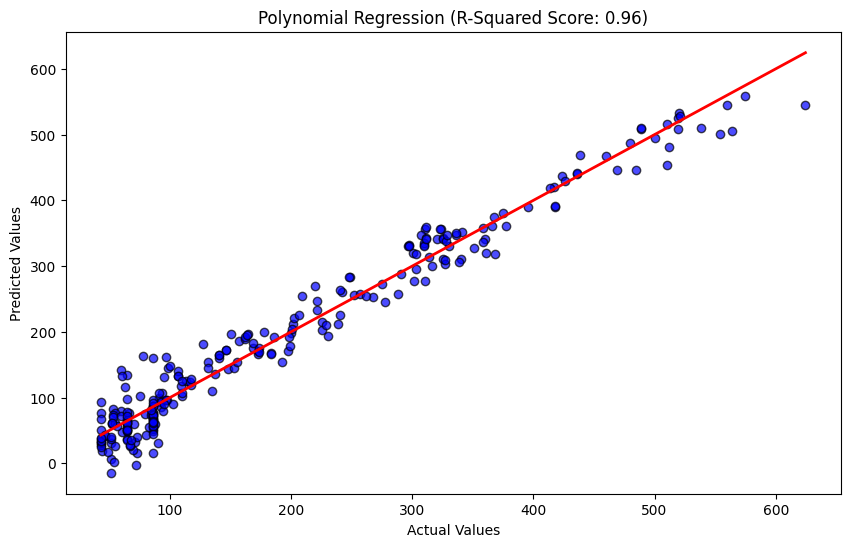

In [ ]:
# Show the scatter plot of the actual and predicted data
plt.figure(figsize=(10, 6))
plt.scatter(yp_test, p_y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([min(yp_test), max(yp_test)], [min(yp_test), max(yp_test)], color='red', lw=2)  # Identity line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Polynomial Regression (R-Squared Score: {:.2f})'.format(p_r2))
plt.show()

In [ ]:
# Extract the coefficients and intercept
intercept = p_model.intercept_
coefficients = p_model.coef_

# Get the feature names for polynomial features
feature_names = poly.get_feature_names_out()

# Print the equation
print("Intercept (β0):", intercept)
print("Coefficients:", coefficients)

# Form the equation as a string for easier reading
equation = f"y = {intercept:.4f}"
for feature_name, coef in zip(feature_names, coefficients):
    equation += f" + ({coef:.4f} * {feature_name})"

print("Equation of the model:")
print(equation)

Intercept (β0): -561.4155216893818
Coefficients: [ 1.74324097e+01  6.31615689e+01 -1.06015563e+02 -1.15060716e+01
  3.81158580e+01  6.19155643e-01  2.10426688e-01 -7.89893940e+00
 -3.44890722e+00 -7.29064655e-01 -5.39076535e-01  1.24251260e-02
  2.54287063e+01  4.11624284e+01  1.37784997e+01 -2.81952835e+00
 -4.30761921e-01  1.06044096e+01  9.24313830e+00  1.65783278e+00
 -9.04988059e-02  3.03697403e-01  4.34939942e-01 -3.40239191e-02
 -6.95380614e-01  2.14774075e-02  1.86342425e-03]
Equation of the model:
y = -561.4155 + (17.4324 * beta) + (63.1616 * B) + (-106.0156 * Df) + (-11.5061 * phi) + (38.1159 * gamma) + (0.6192 * P) + (0.2104 * beta^2) + (-7.8989 * beta B) + (-3.4489 * beta Df) + (-0.7291 * beta phi) + (-0.5391 * beta gamma) + (0.0124 * beta P) + (25.4287 * B^2) + (41.1624 * B Df) + (13.7785 * B phi) + (-2.8195 * B gamma) + (-0.4308 * B P) + (10.6044 * Df^2) + (9.2431 * Df phi) + (1.6578 * Df gamma) + (-0.0905 * Df P) + (0.3037 * phi^2) + (0.4349 * phi gamma) + (-0.0340 * phi

### **5. Support Vector Regressor**

In [ ]:
# Creating and training the regression model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1)
svr_model.fit(X_train, y_train)

SVR(C=100, gamma=0.1)

In [ ]:
# Apply k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
svr_rmse_scores = []
svr_r2_scores = []
svr_mape_scores = []
svr_a20_index_scores = []
svr_a30_index_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    svr_model.fit(X_train_fold, y_train_fold)
    svr_y_val_pred = svr_model.predict(X_val_fold)

    kf_svr_mse = mean_squared_error(y_val_fold, svr_y_val_pred)
    kf_svr_rmse = math.sqrt(kf_svr_mse)
    svr_rmse_scores.append(kf_svr_rmse)

    kf_svr_r2 = r2_score(y_val_fold, svr_y_val_pred)
    svr_r2_scores.append(kf_svr_r2)

    kf_svr_mape = mean_absolute_percentage_error(y_val_fold, svr_y_val_pred)
    svr_mape_scores.append(kf_svr_mape)

    kf_svr_evaluator = RegressionMetric(np.array(y_val_fold), np.array(svr_y_val_pred))
    svr_a20_index_scores.append(kf_svr_evaluator.a20_index())
    svr_a30_index_scores.append(kf_svr_evaluator.a30_index())

print(f"RMSE: {svr_rmse_scores}")
print(f"R-Sq: {svr_r2_scores}")
print(f"MAPE: {svr_mape_scores}")
print(f"A20: {svr_a20_index_scores}")
print(f"A30: {svr_a30_index_scores}")

RMSE: [78.58051178520446, 87.20351257892382, 86.42805767078671, 83.54912422545753, 84.39185036833312]
R-Sq: [0.6653227323490032, 0.6519171335559044, 0.6490559826542946, 0.6599458044179576, 0.6613710262983047]
MAPE: [0.31001729583541693, 0.29259056724357024, 0.352912981572504, 0.28674411945365685, 0.3657974376586106]
A20: [0.6231884057971014, 0.5072463768115942, 0.5555555555555556, 0.5362318840579711, 0.5485436893203883]
A30: [0.7246376811594203, 0.6135265700483091, 0.6714975845410628, 0.7246376811594203, 0.6747572815533981]


In [ ]:
# Predict using train set
svr_train_pred = svr_model.predict(X_train)

# Evaluate the model (rmse, r2 score, mape, a20 and a30 index)
svr_train_mse = mean_squared_error(y_train, svr_train_pred)
svr_train_rmse = math.sqrt(svr_train_mse)
svr_train_r2 = r2_score(y_train, svr_train_pred)
svr_train_mape = mean_absolute_percentage_error(y_train, svr_train_pred)
svr_train_a20_index = RegressionMetric(np.array(y_train), np.array(svr_train_pred)).a20_index()
svr_train_a30_index = RegressionMetric(np.array(y_train), np.array(svr_train_pred)).a30_index()

print(f"RMSE: {svr_train_rmse}")
print(f"R-squared Score: {svr_model.score(X_train, y_train)}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, svr_train_pred)}")
print(f"A20: {svr_train_a20_index}")
print(f"A30: {svr_train_a30_index}")

RMSE: 70.98430870857482
R-squared Score: 0.7559711043230182
MAPE: 0.2454426449755021
A20: 0.6470019342359767
A30: 0.7678916827852998


In [ ]:
# Making predictions on the test set
svr_y_pred = svr_model.predict(X_test)

In [ ]:
# Evaluating the model
svr_mse = mean_squared_error(y_test, svr_y_pred)
svr_rmse = math.sqrt(svr_mse)
svr_r2 = r2_score(y_test, svr_y_pred)
svr_mape = mean_absolute_percentage_error(y_test, svr_y_pred)
svr_a20_index = RegressionMetric(np.array(y_test), np.array(svr_y_pred)).a20_index()
svr_a30_index = RegressionMetric(np.array(y_test), np.array(svr_y_pred)).a30_index()

print(f"RMSE: {(svr_rmse)}")
print(f"R-squared Score: {svr_r2}")
print(f"MAPE: {svr_mape}")
print(f"A20: {svr_a20_index}")
print(f"A30: {svr_a30_index}")

RMSE: 77.10448588730343
R-squared Score: 0.7178412081378929
MAPE: 0.31854294452441756
A20: 0.5057915057915058
A30: 0.6447876447876448


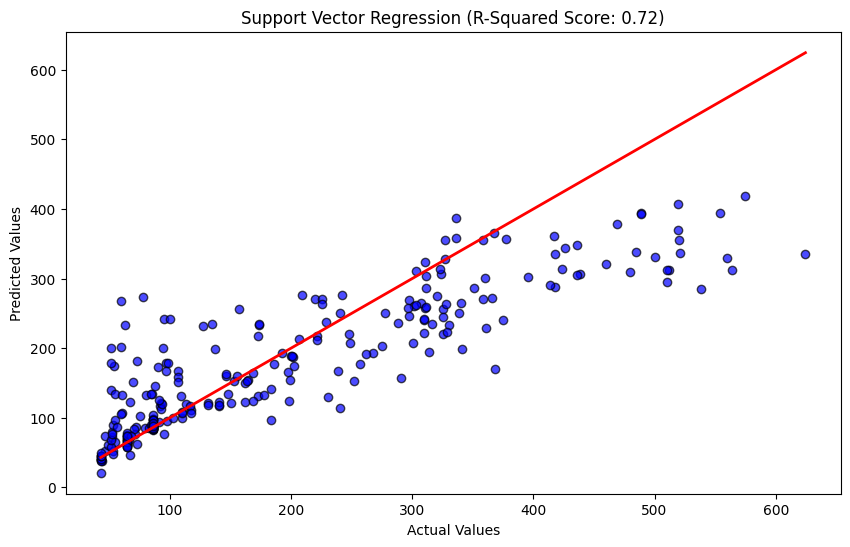

In [ ]:
# Show the scatter plot of the actual and predicted data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, svr_y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Identity line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Support Vector Regression (R-Squared Score: {:.2f})'.format(svr_r2))
plt.show()

### **6. Decision Tree Regressor**

In [ ]:
# Creating and training the regression model
dt_model = DecisionTreeRegressor(max_depth=5)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [ ]:
# Apply k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
dt_rmse_scores = []
dt_r2_scores = []
dt_mape_scores = []
dt_a20_index_scores = []
dt_a30_index_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    dt_model.fit(X_train_fold, y_train_fold)
    dt_y_val_pred = dt_model.predict(X_val_fold)

    kf_dt_mse = mean_squared_error(y_val_fold, dt_y_val_pred)
    kf_dt_rmse = math.sqrt(kf_dt_mse)
    dt_rmse_scores.append(kf_dt_rmse)

    kf_dt_r2 = r2_score(y_val_fold, dt_y_val_pred)
    dt_r2_scores.append(kf_dt_r2)

    kf_dt_mape = mean_absolute_percentage_error(y_val_fold, dt_y_val_pred)
    dt_mape_scores.append(kf_dt_mape)

    kf_dt_evaluator = RegressionMetric(np.array(y_val_fold), np.array(dt_y_val_pred))
    dt_a20_index_scores.append(kf_dt_evaluator.a20_index())
    dt_a30_index_scores.append(kf_dt_evaluator.a30_index())

print(f"RMSE: {dt_rmse_scores}")
print(f"R-Sq: {dt_r2_scores}")
print(f"MAPE: {dt_mape_scores}")
print(f"A20: {dt_a20_index_scores}")
print(f"A30: {dt_a30_index_scores}")

RMSE: [51.12379535351231, 59.51683366092318, 54.48814370147047, 55.07923113298533, 55.59242433043305]
R-Sq: [0.8583414852146989, 0.8378584479386586, 0.8605134404680151, 0.8522116936792021, 0.8530551658647815]
MAPE: [0.24648570113633056, 0.3042638371169798, 0.2539177687056793, 0.24858379011777337, 0.25600157246983535]
A20: [0.6376811594202898, 0.48792270531400966, 0.5314009661835749, 0.5603864734299517, 0.5388349514563107]
A30: [0.7777777777777778, 0.6859903381642513, 0.7294685990338164, 0.748792270531401, 0.6990291262135923]


In [ ]:
# Predict using train set
dt_train_pred = dt_model.predict(X_train)

# Evaluate the model (rmse, r2 score, mape, a20 and a30 index)
dt_train_mse = mean_squared_error(y_train, dt_train_pred)
dt_train_rmse = math.sqrt(dt_train_mse)
dt_train_r2 = r2_score(y_train, dt_train_pred)
dt_train_mape = mean_absolute_percentage_error(y_train, dt_train_pred)
dt_train_a20_index = RegressionMetric(np.array(y_train), np.array(dt_train_pred)).a20_index()
dt_train_a30_index = RegressionMetric(np.array(y_train), np.array(dt_train_pred)).a30_index()

print(f"RMSE: {dt_train_rmse}")
print(f"R-squared Score: {dt_model.score(X_train, y_train)}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, dt_train_pred)}")
print(f"A20: {dt_train_a20_index}")
print(f"A30: {dt_train_a30_index}")

RMSE: 53.80206247471099
R-squared Score: 0.8598108543753284
MAPE: 0.24575797219287895
A20: 0.5493230174081238
A30: 0.7321083172147002


In [ ]:
# Making predictions on the test set
dt_y_pred = dt_model.predict(X_test)

In [ ]:
# Evaluating the model
dt_mse = mean_squared_error(y_test, dt_y_pred)
dt_rmse = math.sqrt(dt_mse)
dt_r2 = r2_score(y_test, dt_y_pred)
dt_mape = mean_absolute_percentage_error(y_test, dt_y_pred)
dt_a20_index = RegressionMetric(np.array(y_test), np.array(dt_y_pred)).a20_index()
dt_a30_index = RegressionMetric(np.array(y_test), np.array(dt_y_pred)).a30_index()

print(f"RMSE: {dt_rmse}")
print(f"R-squared Score: {dt_r2}")
print(f"MAPE: {dt_mape}")
print(f"A20: {dt_a20_index}")
print(f"A30: {dt_a30_index}")

RMSE: 55.98279234986469
R-squared Score: 0.8512546461843616
MAPE: 0.23864253544620076
A20: 0.525096525096525
A30: 0.7142857142857143


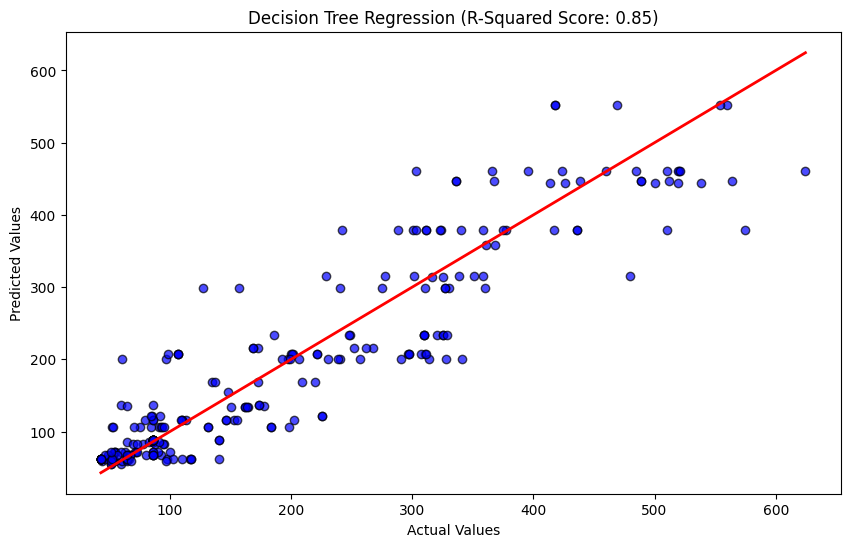

In [ ]:
# Show the scatter plot of the actual and predicted data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, dt_y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Identity line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Regression (R-Squared Score: {:.2f})'.format(dt_r2))
plt.show()

### **7. Random Forest Regressor**

In [ ]:
# Creating and training the regression model
rf_model = RandomForestRegressor(max_depth=5, random_state=0)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=0)

In [ ]:
# Apply k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_rmse_scores = []
rf_r2_scores = []
rf_mape_scores = []
rf_a20_index_scores = []
rf_a30_index_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    rf_model.fit(X_train_fold, y_train_fold)
    rf_y_val_pred = rf_model.predict(X_val_fold)

    kf_rf_mse = mean_squared_error(y_val_fold, rf_y_val_pred)
    kf_rf_rmse = math.sqrt(kf_rf_mse)
    rf_rmse_scores.append(kf_rf_rmse)

    kf_rf_r2 = r2_score(y_val_fold, rf_y_val_pred)
    rf_r2_scores.append(kf_rf_r2)

    kf_rf_mape = mean_absolute_percentage_error(y_val_fold, rf_y_val_pred)
    rf_mape_scores.append(kf_rf_mape)

    kf_rf_evaluator = RegressionMetric(np.array(y_val_fold), np.array(rf_y_val_pred))
    rf_a20_index_scores.append(kf_rf_evaluator.a20_index())
    rf_a30_index_scores.append(kf_rf_evaluator.a30_index())

print(f"RMSE: {rf_rmse_scores}")
print(f"R-Sq: {rf_r2_scores}")
print(f"MAPE: {rf_mape_scores}")
print(f"A20: {rf_a20_index_scores}")
print(f"A30: {rf_a30_index_scores}")

RMSE: [40.418888950081886, 54.02110555337666, 47.67853783725726, 48.59682782764162, 46.07082732335645]
R-Sq: [0.9114547535034987, 0.8664199428646282, 0.8931992767035575, 0.8849517076990479, 0.8990804934741791]
MAPE: [0.18839278510621235, 0.2455335913198229, 0.21421357155534798, 0.19881303844026887, 0.20793684411668517]
A20: [0.6714975845410628, 0.5362318840579711, 0.5990338164251208, 0.6570048309178744, 0.6359223300970874]
A30: [0.8454106280193237, 0.7729468599033816, 0.821256038647343, 0.8502415458937198, 0.7815533980582524]


In [ ]:
# Predict using train set
rf_train_pred = rf_model.predict(X_train)

# Evaluate the model (rmse, r2 score, mape, a20 and a30 index)
rf_train_mse = mean_squared_error(y_train, rf_train_pred)
rf_train_rmse = math.sqrt(rf_train_mse)
rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_train_mape = mean_absolute_percentage_error(y_train, rf_train_pred)
rf_train_a20_index = RegressionMetric(np.array(y_train), np.array(rf_train_pred)).a20_index()
rf_train_a30_index = RegressionMetric(np.array(y_train), np.array(rf_train_pred)).a30_index()

print(f"RMSE: {rf_train_rmse}")
print(f"R-squared Score: {rf_model.score(X_train, y_train)}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, rf_train_pred)}")
print(f"A20: {rf_train_a20_index}")
print(f"A30: {rf_train_a30_index}")

RMSE: 44.71399439327356
R-squared Score: 0.903171439354208
MAPE: 0.20011838331082005
A20: 0.6470019342359767
A30: 0.8172147001934236


In [ ]:
# Making predictions on the test set
rf_y_pred = rf_model.predict(X_test)

In [ ]:
# Evaluating the model
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = math.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_y_pred)
rf_mape = mean_absolute_percentage_error(y_test, rf_y_pred)
rf_a20_index = RegressionMetric(np.array(y_test), np.array(rf_y_pred)).a20_index()
rf_a30_index = RegressionMetric(np.array(y_test), np.array(rf_y_pred)).a30_index()

print(f"RMSE: {rf_rmse}")
print(f"R-squared Score: {rf_r2}")
print(f"MAPE: {rf_mape}")
print(f"A20: {rf_a20_index}")
print(f"A30: {rf_a30_index}")

RMSE: 46.308278352646916
R-squared Score: 0.8982225499363325
MAPE: 0.20462609623151662
A20: 0.6138996138996139
A30: 0.803088803088803


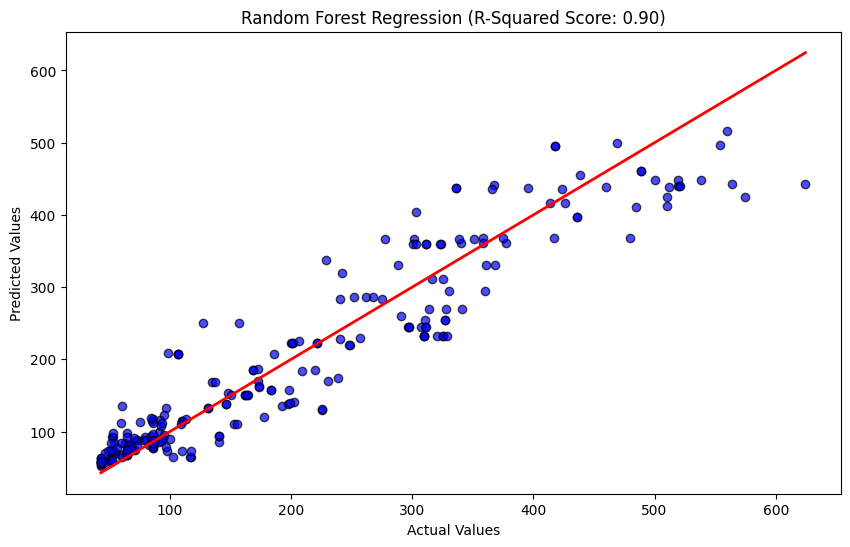

In [ ]:
# Show the scatter plot of the actual and predicted data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Identity line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression (R-Squared Score: {:.2f})'.format(rf_r2))
plt.show()

### **8. XGBoost Regressor**

In [ ]:
# Creating and training the regression model
xgb_model = xgb.XGBRegressor( n_estimators = 10, seed = 123)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
# Apply k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_rmse_scores = []
xgb_r2_scores = []
xgb_mape_scores = []
xgb_a20_index_scores = []
xgb_a30_index_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    xgb_model.fit(X_train_fold, y_train_fold)
    xgb_y_val_pred = xgb_model.predict(X_val_fold)

    kf_xgb_mse = mean_squared_error(y_val_fold, xgb_y_val_pred)
    kf_xgb_rmse = math.sqrt(kf_xgb_mse)
    xgb_rmse_scores.append(kf_xgb_rmse)

    kf_xgb_r2 = r2_score(y_val_fold, xgb_y_val_pred)
    xgb_r2_scores.append(kf_xgb_r2)

    kf_xgb_mape = mean_absolute_percentage_error(y_val_fold, xgb_y_val_pred)
    xgb_mape_scores.append(kf_xgb_mape)

    kf_xgb_evaluator = RegressionMetric(np.array(y_val_fold), np.array(xgb_y_val_pred))
    xgb_a20_index_scores.append(kf_xgb_evaluator.a20_index())
    xgb_a30_index_scores.append(kf_xgb_evaluator.a30_index())

print(f"RMSE: {xgb_rmse_scores}")
print(f"R-Sq: {xgb_r2_scores}")
print(f"MAPE: {xgb_mape_scores}")
print(f"A20: {xgb_a20_index_scores}")
print(f"A30: {xgb_a30_index_scores}")

RMSE: [18.73224216192089, 20.464590902374574, 21.95711758166405, 19.683415195433522, 19.35498743128901]
R-Sq: [0.9809815098606994, 0.9808300569030152, 0.9773494374691614, 0.9811259439435307, 0.9821881559905962]
MAPE: [0.07982545569159391, 0.08353607775325582, 0.08989583483531918, 0.07971980474858789, 0.086440981824173]
A20: [0.9130434782608695, 0.9371980676328503, 0.9082125603864735, 0.9371980676328503, 0.9223300970873787]
A30: [0.9710144927536232, 0.9806763285024155, 0.9806763285024155, 0.966183574879227, 0.970873786407767]


In [ ]:
# Predict using train set
xgb_train_pred = xgb_model.predict(X_train)

# Evaluate the model (rmse, r2 score, mape, a20 and a30 index)
xgb_train_mse = mean_squared_error(y_train, xgb_train_pred)
xgb_train_rmse = math.sqrt(xgb_train_mse)
xgb_train_r2 = r2_score(y_train, xgb_train_pred)
xgb_train_mape = mean_absolute_percentage_error(y_train, xgb_train_pred)
xgb_train_a20_index = RegressionMetric(np.array(y_train), np.array(xgb_train_pred)).a20_index()
xgb_train_a30_index = RegressionMetric(np.array(y_train), np.array(xgb_train_pred)).a30_index()

print(f"RMSE: {xgb_train_rmse}")
print(f"R-squared Score: {xgb_model.score(X_train, y_train)}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, xgb_train_pred)}")
print(f"A20: {xgb_train_a20_index}")
print(f"A30: {xgb_train_a30_index}")

RMSE: 17.362572039940243
R-squared Score: 0.9854002754712173
MAPE: 0.07428429194770984
A20: 0.9458413926499033
A30: 0.9796905222437138


In [ ]:
# Making predictions on the test set
xgb_y_pred = xgb_model.predict(X_test)

In [ ]:
# Evaluating the model
xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_rmse = math.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_y_pred)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_y_pred)
xgb_a20_index = RegressionMetric(np.array(y_test), np.array(xgb_y_pred)).a20_index()
xgb_a30_index = RegressionMetric(np.array(y_test), np.array(xgb_y_pred)).a30_index()

print(f"RMSE: {xgb_rmse}")
print(f"R-squared Score: {xgb_r2}")
print(f"MAPE: {xgb_mape}")
print(f"A20: {xgb_a20_index}")
print(f"A30: {xgb_a30_index}")

RMSE: 19.203386720971395
R-squared Score: 0.9824979084421401
MAPE: 0.08370832338607907
A20: 0.918918918918919
A30: 0.9613899613899614


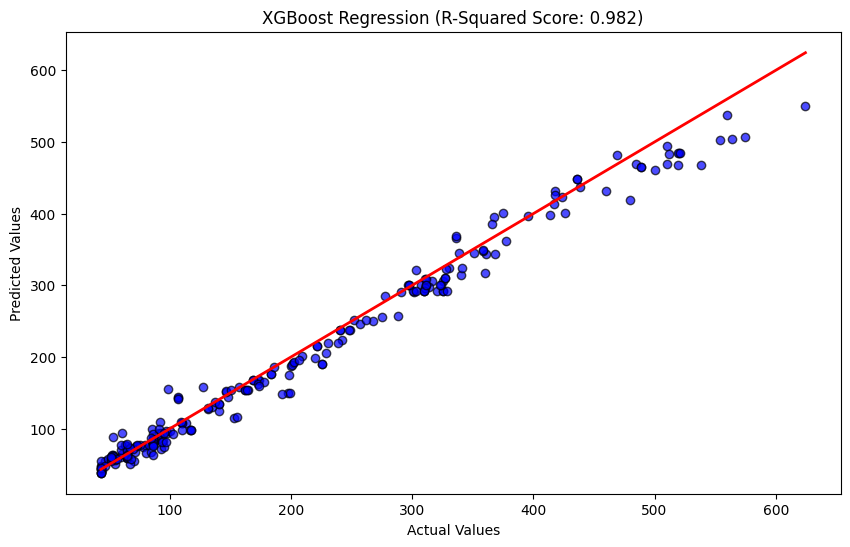

In [ ]:
# Show the scatter plot of the actual and predicted data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Identity line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Regression (R-Squared Score: {:.3f})'.format(xgb_r2))
plt.show()

### **9. KNeighbours Regressor**

In [ ]:
# Use GridSearch to find the best value of 'n_neighbors'
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = KNeighborsRegressor()

knn_gscv = GridSearchCV(knn, params, cv=5)
knn_gscv.fit(X_train,y_train)
knn_gscv.best_params_

{'n_neighbors': 2}

KNeighbors with the 'n_neighbors'=2 would be able to make the best prediction with this dataset.

In [ ]:
# Creating and training the regression model
kn_model = KNeighborsRegressor(n_neighbors=2)
kn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [ ]:
# Apply k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kn_rmse_scores = []
kn_r2_scores = []
kn_mape_scores = []
kn_a20_index_scores = []
kn_a30_index_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    kn_model.fit(X_train_fold, y_train_fold)
    kn_y_val_pred = kn_model.predict(X_val_fold)

    kf_kn_mse = mean_squared_error(y_val_fold, kn_y_val_pred)
    kf_kn_rmse = math.sqrt(kf_kn_mse)
    kn_rmse_scores.append(kf_kn_rmse)

    kf_kn_r2 = r2_score(y_val_fold, kn_y_val_pred)
    kn_r2_scores.append(kf_kn_r2)

    kf_kn_mape = mean_absolute_percentage_error(y_val_fold, kn_y_val_pred)
    kn_mape_scores.append(kf_kn_mape)

    kf_kn_evaluator = RegressionMetric(np.array(y_val_fold), np.array(kn_y_val_pred))
    kn_a20_index_scores.append(kf_kn_evaluator.a20_index())
    kn_a30_index_scores.append(kf_kn_evaluator.a30_index())

print(f"RMSE: {kn_rmse_scores}")
print(f"R-Sq: {kn_r2_scores}")
print(f"MAPE: {kn_mape_scores}")
print(f"A20: {kn_a20_index_scores}")
print(f"A30: {kn_a30_index_scores}")

RMSE: [81.2972431912014, 85.8387475560903, 88.31645524151514, 83.29386705794965, 81.73279167671204]
R-Sq: [0.6417813883653005, 0.6627271100990557, 0.6335526410053021, 0.6620204802459879, 0.6823742074074399]
MAPE: [0.3079666076542222, 0.2860176007938729, 0.3622167433754411, 0.3039650500590393, 0.3747347685785567]
A20: [0.642512077294686, 0.5410628019323671, 0.5652173913043478, 0.5700483091787439, 0.6116504854368932]
A30: [0.7342995169082126, 0.6763285024154589, 0.6811594202898551, 0.6666666666666666, 0.6844660194174758]


In [ ]:
# Predict using train set
kn_train_pred = kn_model.predict(X_train)

# Evaluate the model (rmse, r2 score, mape, a20 and a30 index)
kn_train_mse = mean_squared_error(y_train, kn_train_pred)
kn_train_rmse = math.sqrt(kn_train_mse)
kn_train_r2 = r2_score(y_train, kn_train_pred)
kn_train_mape = mean_absolute_percentage_error(y_train, kn_train_pred)
kn_train_a20_index = RegressionMetric(np.array(y_train), np.array(kn_train_pred)).a20_index()
kn_train_a30_index = RegressionMetric(np.array(y_train), np.array(kn_train_pred)).a30_index()

print(f"RMSE: {kn_train_rmse}")
print(f"R-squared Score: {kn_model.score(X_train, y_train)}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, kn_train_pred)}")
print(f"A20: {kn_train_a20_index}")
print(f"A30: {kn_train_a30_index}")

RMSE: 53.62818558611748
R-squared Score: 0.8607155135225566
MAPE: 0.2059342460339362
A20: 0.7243713733075435
A30: 0.8558994197292069


In [ ]:
# Making predictions on the test set
kn_y_pred = kn_model.predict(X_test)

In [ ]:
# Evaluating the model
kn_mse = mean_squared_error(y_test, kn_y_pred)
kn_rmse = math.sqrt(kn_mse)
kn_r2 = r2_score(y_test, kn_y_pred)
kn_mape = mean_absolute_percentage_error(y_test, kn_y_pred)
kn_a20_index = RegressionMetric(np.array(y_test), np.array(kn_y_pred)).a20_index()
kn_a30_index = RegressionMetric(np.array(y_test), np.array(kn_y_pred)).a30_index()

print(f"RMSE: {kn_rmse}")
print(f"R-squared Score: {kn_r2}")
print(f"MAPE: {kn_mape_scores}")
print(f"A20: {kn_a20_index}")
print(f"A30: {kn_a30_index}")

RMSE: 75.44265525450055
R-squared Score: 0.7298728564463193
MAPE: [0.3079666076542222, 0.2860176007938729, 0.3622167433754411, 0.3039650500590393, 0.3747347685785567]
A20: 0.5791505791505791
A30: 0.6756756756756757


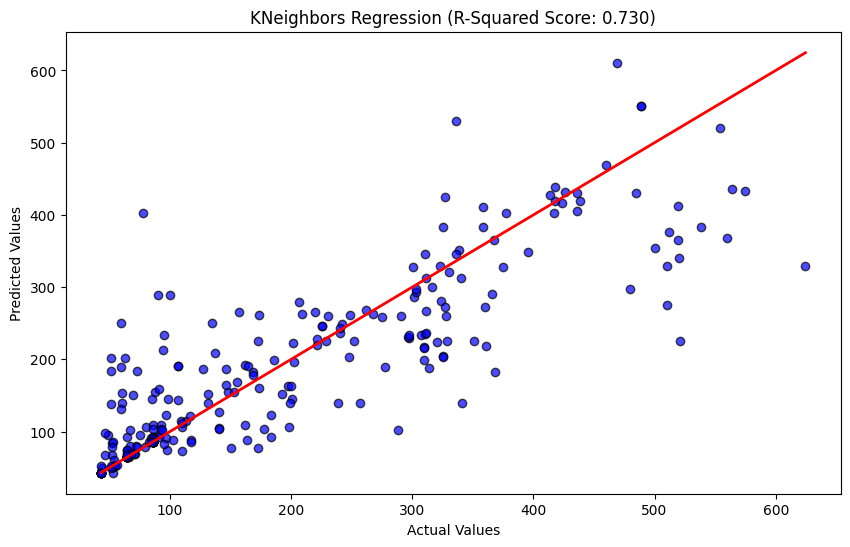

In [ ]:
# Show the scatter plot of the actual and predicted data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, kn_y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Identity line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('KNeighbors Regression (R-Squared Score: {:.3f})'.format(kn_r2))
plt.show()

### **10. Feed Forward Neural Network**

In [ ]:
# Custom RMSE loss function
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Building the feedforward neural network model
fnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compiling the model
fnn_model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=[root_mean_squared_error])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Training the model with early stopping
fnn_history = fnn_model.fit(X_train, y_train, epochs=250, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/250


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 189.5483 - root_mean_squared_error: 189.5655 - val_loss: 189.1466 - val_root_mean_squared_error: 183.6842
Epoch 2/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 174.5453 - root_mean_squared_error: 174.5462 - val_loss: 160.9922 - val_root_mean_squared_error: 156.2958
Epoch 3/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 147.2078 - root_mean_squared_error: 147.2196 - val_loss: 153.9871 - val_root_mean_squared_error: 150.2690
Epoch 4/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 143.5163 - root_mean_squared_error: 143.5241 - val_loss: 152.4097 - val_root_mean_squared_error: 148.4090
Epoch 5/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 143.0930 - root_mean_squared_error: 143.1039 - val_loss: 149.3128 - val_root_mean_squared_error: 145.5114
Epoch 6/250
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 137.4865 - root_mean_squared_error: 137.4887 - val_loss: 147.1172 - val_root_mean_squared_error: 143.1396
Epoch 7/250
26/26 ━━━

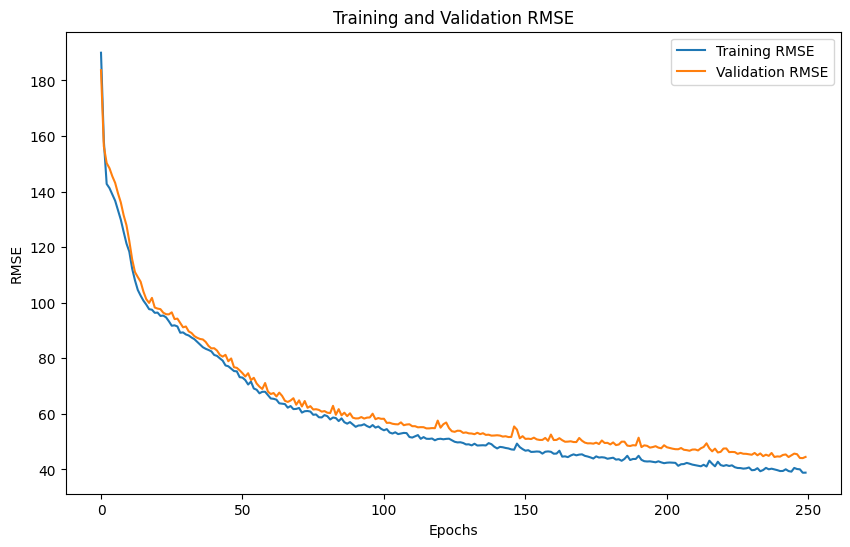

In [ ]:
# Visualizing the RMSE
plt.figure(figsize=(10, 6))
plt.plot(fnn_history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(fnn_history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

In [ ]:
# Apply k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fnn_rmse_scores = []
fnn_r2_scores = []
fnn_mape_scores = []
fnn_a20_index_scores = []
fnn_a30_index_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    fnn_model.fit(X_train_fold, y_train_fold, epochs=250, validation_data=(X_val_fold, y_val_fold),
                  verbose=0, callbacks=[early_stopping])

    fnn_y_val_pred = fnn_model.predict(X_val_fold).flatten()

    kf_fnn_mse = mean_squared_error(y_val_fold, fnn_y_val_pred)
    kf_fnn_rmse = math.sqrt(kf_fnn_mse)
    fnn_rmse_scores.append(kf_fnn_rmse)

    kf_fnn_r2 = r2_score(y_val_fold, fnn_y_val_pred)
    fnn_r2_scores.append(kf_fnn_r2)

    kf_fnn_mape = mean_absolute_percentage_error(y_val_fold, fnn_y_val_pred)
    fnn_mape_scores.append(kf_fnn_mape)

    kf_fnn_evaluator = RegressionMetric(np.array(y_val_fold), np.array(fnn_y_val_pred))
    fnn_a20_index_scores.append(kf_fnn_evaluator.a20_index())
    fnn_a30_index_scores.append(kf_fnn_evaluator.a30_index())

print(f"RMSE: {fnn_rmse_scores}")
print(f"R-Sq: {fnn_r2_scores}")
print(f"MAPE: {fnn_mape_scores}")
print(f"A20: {fnn_a20_index_scores}")
print(f"A30: {fnn_a30_index_scores}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE: [31.336165441149692, 29.211181951323148, 25.484564459485846, 21.763861545778262, 19.722097666789814]
R-Sq: [0.9467783650779199, 0.9609417348887794, 0.9694871503819767, 0.9769252904807464, 0.9815060658848428]
MAPE: [0.14757209899089282, 0.13855892732497624, 0.13585179874528563, 0.1180128309679115, 0.11447980484499609]
A20: [0.7971014492753623, 0.7874396135265701, 0.7971014492753623, 0.8067632850241546, 0.8155339805825242]
A30: [0.8888888888888888, 0.8985507246376812, 0.9033816425120773, 0.893719806763285, 0.9514563106796117]


In [ ]:
# Predict using train set
fnn_train_pred = fnn_model.predict(X_train)

# Evaluate the model (rmse, r2 score, mape, a20 and a30 index)
fnn_train_mse = mean_squared_error(y_train, fnn_train_pred)
fnn_train_rmse = math.sqrt(fnn_train_mse)
fnn_train_r2 = r2_score(y_train, fnn_train_pred)
fnn_train_mape = mean_absolute_percentage_error(y_train, fnn_train_pred)
fnn_train_a20_index = RegressionMetric(np.array(y_train), np.array(fnn_train_pred)).a20_index()
fnn_train_a30_index = RegressionMetric(np.array(y_train), np.array(fnn_train_pred)).a30_index()

print(f"RMSE: {fnn_train_rmse}")
print(f"R-squared Score: {fnn_train_r2}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, fnn_train_pred)}")
print(f"A20: {fnn_train_a20_index}")
print(f"A30: {fnn_train_a30_index}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 22.40688730133402
R-squared Score: 0.9756847018201321
MAPE: 0.12041117426436353
A20: 0.8210831721470019
A30: 0.925531914893617


In [ ]:
# Making predictions on the test set
fnn_y_pred = fnn_model.predict(X_test)

# Evaluating the model
fnn_mse = mean_squared_error(y_test, fnn_y_pred)
fnn_rmse = math.sqrt(fnn_mse)
fnn_r2 = r2_score(y_test, fnn_y_pred)
fnn_mape = mean_absolute_percentage_error(y_test, fnn_y_pred)
fnn_a20_index = RegressionMetric(np.array(y_test), np.array(fnn_y_pred)).a20_index()
fnn_a30_index = RegressionMetric(np.array(y_test), np.array(fnn_y_pred)).a30_index()

print(f"RMSE: {fnn_rmse}")
print(f"R-squared Score: {fnn_r2}")
print(f"MAPE: {fnn_mape}")
print(f"A20: {fnn_a20_index}")
print(f"A30: {fnn_a30_index}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
RMSE: 23.694488196384647
R-squared Score: 0.9733541879460871
MAPE: 0.13164351456234896
A20: 0.8108108108108109
A30: 0.8918918918918919


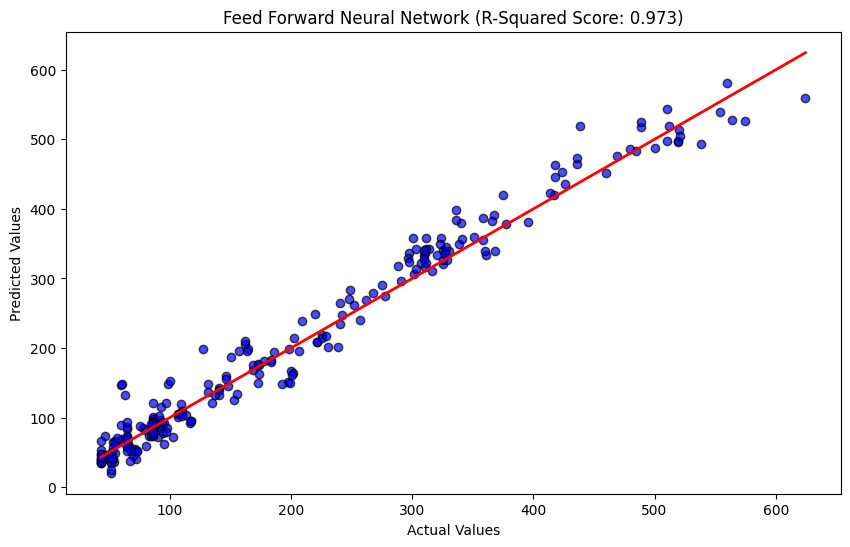

In [ ]:
# Show the scatter plot of the actual and predicted data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, fnn_y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Identity line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Feed Forward Neural Network (R-Squared Score: {:.3f})'.format(fnn_r2))
plt.show()

# **CONCLUSIONS**

## **Root Mean Squared Error (RMSE) and R-Squared**

<Axes: title={'center': 'A30 Index Comparison'}, ylabel='Algorithm'>

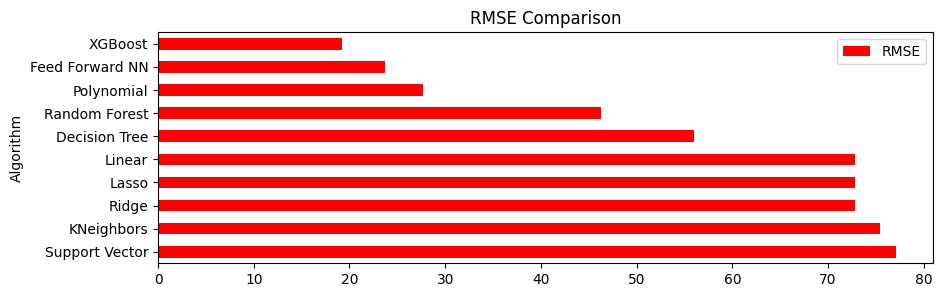

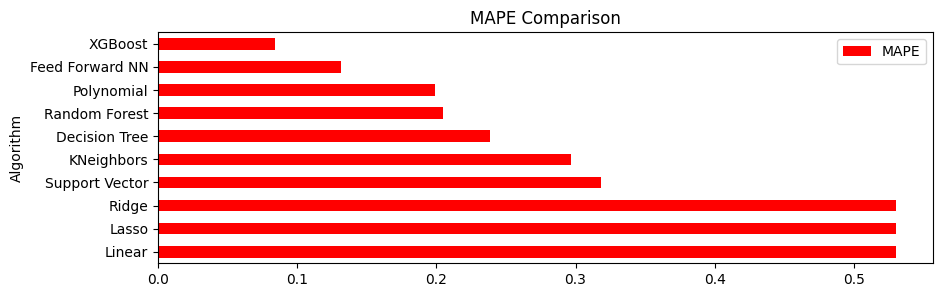

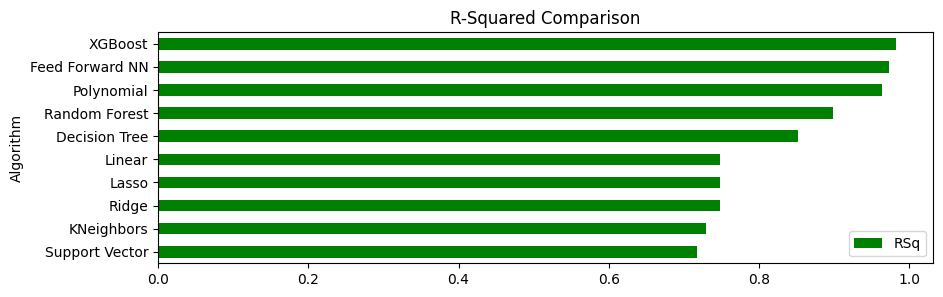

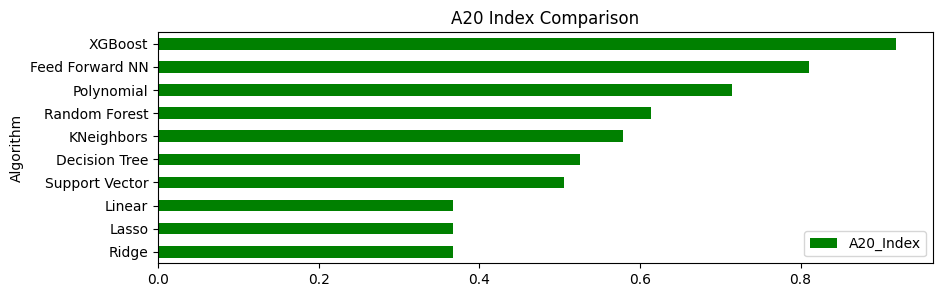

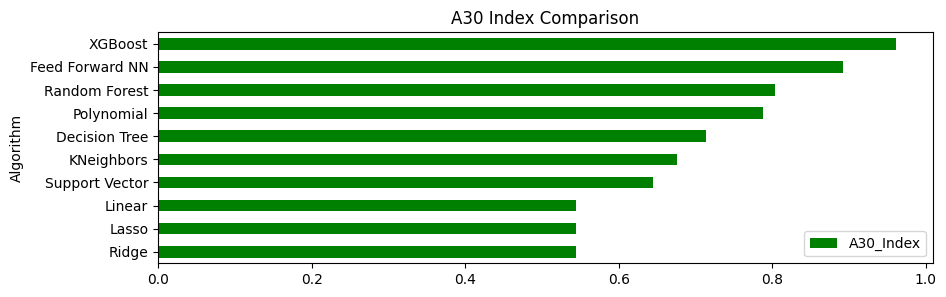

In [ ]:
# Make a dictionary of the metrics
metrics = {
    'Algorithm' : ['Linear', 'Ridge', 'Lasso', 'Polynomial', 'Support Vector', 'Decision Tree', 'Random Forest',
                   'XGBoost', 'KNeighbors', 'Feed Forward NN'],
    'RMSE' : [lr_rmse, r_rmse, l_rmse, p_rmse, svr_rmse, dt_rmse, rf_rmse, xgb_rmse, kn_rmse, fnn_rmse],
    'RSq' : [lr_r2, r_r2, l_r2, p_r2, svr_r2, dt_r2, rf_r2, xgb_r2, kn_r2, fnn_r2],
    'MAPE' : [lr_mape, r_mape, l_mape, p_mape, svr_mape, dt_mape, rf_mape, xgb_mape, kn_mape, fnn_mape],
    'A20_Index' : [lr_a20_index, r_a20_index, l_a20_index, p_a20_index, svr_a20_index, dt_a20_index, rf_a20_index, xgb_a20_index, kn_a20_index, fnn_a20_index],
    'A30_Index' : [lr_a30_index, r_a30_index, l_a30_index, p_a30_index, svr_a30_index, dt_a30_index, rf_a30_index, xgb_a30_index, kn_a30_index, fnn_a30_index],
    'F1_RMSE' : [lr_rmse_scores[0], r_rmse_scores[0], l_rmse_scores[0], p_rmse_scores[0], svr_rmse_scores[0], dt_rmse_scores[0], rf_rmse_scores[0], xgb_rmse_scores[0], kn_rmse_scores[0], fnn_rmse_scores[0]],
    'F2_RMSE' : [lr_rmse_scores[1], r_rmse_scores[1], l_rmse_scores[1], p_rmse_scores[1], svr_rmse_scores[1], dt_rmse_scores[1], rf_rmse_scores[1], xgb_rmse_scores[1], kn_rmse_scores[1], fnn_rmse_scores[1]],
    'F3_RMSE' : [lr_rmse_scores[2], r_rmse_scores[2], l_rmse_scores[2], p_rmse_scores[2], svr_rmse_scores[2], dt_rmse_scores[2], rf_rmse_scores[2], xgb_rmse_scores[2], kn_rmse_scores[2], fnn_rmse_scores[2]],
    'F4_RMSE' : [lr_rmse_scores[3], r_rmse_scores[3], l_rmse_scores[3], p_rmse_scores[3], svr_rmse_scores[3], dt_rmse_scores[3], rf_rmse_scores[3], xgb_rmse_scores[3], kn_rmse_scores[3], fnn_rmse_scores[3]],
    'F5_RMSE' : [lr_rmse_scores[4], r_rmse_scores[4], l_rmse_scores[4], p_rmse_scores[4], svr_rmse_scores[4], dt_rmse_scores[4], rf_rmse_scores[4], xgb_rmse_scores[4], kn_rmse_scores[4], fnn_rmse_scores[4]],
    'F1_RSq' : [lr_r2_scores[0], r_r2_scores[0], l_r2_scores[0], p_r2_scores[0], svr_r2_scores[0], dt_r2_scores[0], rf_r2_scores[0], xgb_r2_scores[0], kn_r2_scores[0], fnn_r2_scores[0]],
    'F2_RSq' : [lr_r2_scores[1], r_r2_scores[1], l_r2_scores[1], p_r2_scores[1], svr_r2_scores[1], dt_r2_scores[1], rf_r2_scores[1], xgb_r2_scores[1], kn_r2_scores[1], fnn_r2_scores[1]],
    'F3_RSq' : [lr_r2_scores[2], r_r2_scores[2], l_r2_scores[2], p_r2_scores[2], svr_r2_scores[2], dt_r2_scores[2], rf_r2_scores[2], xgb_r2_scores[2], kn_r2_scores[2], fnn_r2_scores[2]],
    'F4_RSq' : [lr_r2_scores[3], r_r2_scores[3], l_r2_scores[3], p_r2_scores[3], svr_r2_scores[3], dt_r2_scores[3], rf_r2_scores[3], xgb_r2_scores[3], kn_r2_scores[3], fnn_r2_scores[3]],
    'F5_RSq' : [lr_r2_scores[4], r_r2_scores[4], l_r2_scores[4], p_r2_scores[4], svr_r2_scores[3], dt_r2_scores[4], rf_r2_scores[4], xgb_r2_scores[4], kn_r2_scores[4], fnn_r2_scores[4]],
    'F1_MAPE' : [lr_mape_scores[0], r_mape_scores[0], l_mape_scores[0], p_mape_scores[0], svr_mape_scores[0], dt_mape_scores[0], rf_mape_scores[0], xgb_mape_scores[0], kn_mape_scores[0], fnn_mape_scores[0]],
    'F2_MAPE' : [lr_mape_scores[1], r_mape_scores[1], l_mape_scores[1], p_mape_scores[1], svr_mape_scores[1], dt_mape_scores[1], rf_mape_scores[1], xgb_mape_scores[1], kn_mape_scores[1], fnn_mape_scores[1]],
    'F3_MAPE' : [lr_mape_scores[2], r_mape_scores[2], l_mape_scores[2], p_mape_scores[2], svr_mape_scores[2], dt_mape_scores[2], rf_mape_scores[2], xgb_mape_scores[2], kn_mape_scores[2], fnn_mape_scores[2]],
    'F4_MAPE' : [lr_mape_scores[3], r_mape_scores[3], l_mape_scores[3], p_mape_scores[3], svr_mape_scores[3], dt_mape_scores[3], rf_mape_scores[3], xgb_mape_scores[3], kn_mape_scores[3], fnn_mape_scores[3]],
    'F5_MAPE' : [lr_mape_scores[4], r_mape_scores[4], l_mape_scores[4], p_mape_scores[4], svr_mape_scores[4], dt_mape_scores[4], rf_mape_scores[4], xgb_mape_scores[4], kn_mape_scores[4], fnn_mape_scores[4]],
    'F1_A20' : [lr_a20_index_scores[0], r_a20_index_scores[0], l_a20_index_scores[0], p_a20_index_scores[0], svr_a20_index_scores[0], dt_a20_index_scores[0], rf_a20_index_scores[0], xgb_a20_index_scores[0], kn_a20_index_scores[0], fnn_a20_index_scores[0]],
    'F2_A20' : [lr_a20_index_scores[1], r_a20_index_scores[1], l_a20_index_scores[1], p_a20_index_scores[1], svr_a20_index_scores[1], dt_a20_index_scores[1], rf_a20_index_scores[1], xgb_a20_index_scores[1], kn_a20_index_scores[1], fnn_a20_index_scores[1]],
    'F3_A20' : [lr_a20_index_scores[2], r_a20_index_scores[2], l_a20_index_scores[2], p_a20_index_scores[2], svr_a20_index_scores[2], dt_a20_index_scores[2], rf_a20_index_scores[2], xgb_a20_index_scores[2], kn_a20_index_scores[2], fnn_a20_index_scores[2]],
    'F4_A20' : [lr_a20_index_scores[3], r_a20_index_scores[3], l_a20_index_scores[3], p_a20_index_scores[3], svr_a20_index_scores[3], dt_a20_index_scores[3], rf_a20_index_scores[3], xgb_a20_index_scores[3], kn_a20_index_scores[3], fnn_a20_index_scores[3]],
    'F5_A20' : [lr_a20_index_scores[4], r_a20_index_scores[4], l_a20_index_scores[4], p_a20_index_scores[4], svr_a20_index_scores[4], dt_a20_index_scores[4], rf_a20_index_scores[4], xgb_a20_index_scores[4], kn_a20_index_scores[4], fnn_a20_index_scores[4]],
    'F1_A30' : [lr_a30_index_scores[0], r_a30_index_scores[0], l_a30_index_scores[0], p_a30_index_scores[0], svr_a30_index_scores[0], dt_a30_index_scores[0], rf_a30_index_scores[0], xgb_a30_index_scores[0], kn_a30_index_scores[0], fnn_a30_index_scores[0]],
    'F2_A30' : [lr_a30_index_scores[1], r_a30_index_scores[1], l_a30_index_scores[1], p_a30_index_scores[1], svr_a30_index_scores[1], dt_a30_index_scores[1], rf_a30_index_scores[1], xgb_a30_index_scores[1], kn_a30_index_scores[1], fnn_a30_index_scores[1]],
    'F3_A30' : [lr_a30_index_scores[2], r_a30_index_scores[2], l_a30_index_scores[2], p_a30_index_scores[2], svr_a30_index_scores[2], dt_a30_index_scores[2], rf_a30_index_scores[2], xgb_a30_index_scores[2], kn_a30_index_scores[2], fnn_a30_index_scores[2]],
    'F4_A30' : [lr_a30_index_scores[3], r_a30_index_scores[3], l_a30_index_scores[3], p_a30_index_scores[3], svr_a30_index_scores[3], dt_a30_index_scores[3], rf_a30_index_scores[3], xgb_a30_index_scores[3], kn_a30_index_scores[3], fnn_a30_index_scores[3]],
    'F5_A30' : [lr_a30_index_scores[4], r_a30_index_scores[4], l_a30_index_scores[4], p_a30_index_scores[4], svr_a30_index_scores[4], dt_a30_index_scores[4], rf_a30_index_scores[4], xgb_a30_index_scores[4], kn_a30_index_scores[4], fnn_a30_index_scores[4]]
}

# Transform the dictionary into a dataframe
metrics_df = pd.DataFrame(metrics)

# Visualiza the RMSE using bar chart in descending order
metrics_df.sort_values('RMSE',ascending=False,inplace=True)
metrics_df.plot(kind='barh',y='RMSE',x='Algorithm',color='r', figsize=(10, 3), title="RMSE Comparison")

# Visualiza the MAPE using bar chart in descending order
metrics_df.sort_values('MAPE',ascending=False,inplace=True)
metrics_df.plot(kind='barh',y='MAPE',x='Algorithm',color='r', figsize=(10, 3), title="MAPE Comparison")

# Visualize the R_squared using bar chart in ascending order
metrics_df.sort_values('RSq', inplace=True)
metrics_df.plot(kind='barh',y='RSq',x='Algorithm',color='g', figsize=(10, 3), title="R-Squared Comparison")

# Visualize the A20_Index using bar chart in ascending order
metrics_df.sort_values('A20_Index', inplace=True)
metrics_df.plot(kind='barh',y='A20_Index',x='Algorithm',color='g', figsize=(10, 3), title="A20 Index Comparison")

# Visualize the A30_Index using bar chart in ascending order
metrics_df.sort_values('A30_Index', inplace=True)
metrics_df.plot(kind='barh',y='A30_Index',x='Algorithm',color='g', figsize=(10, 3), title="A30 Index Comparison")

## **Shapley Additive Explanations (SHAP)**

### **1. Multiple Linear Regression**

Overall SHAP Values for Each Feature:
beta     77.351245
B        43.962136
Df       30.990384
phi      66.536245
gamma     7.017225
P         5.983645
dtype: float64


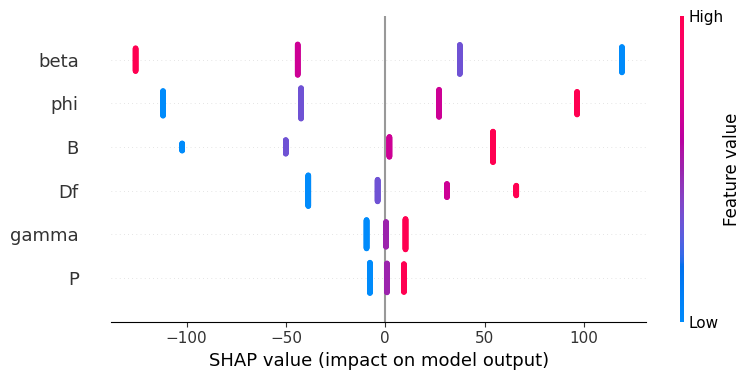

In [ ]:
# Initialize SHAP explainer
lr_explainer = shap.Explainer(lr_model, X_train)

# Calculate SHAP values
lr_shap_values = lr_explainer(X_test)

# Get overall SHAP values for each variable
lr_shap_df = pd.DataFrame(lr_shap_values.values, columns=X.columns)
lr_overall_shap = lr_shap_df.abs().mean()

print("Overall SHAP Values for Each Feature:")
print(lr_overall_shap)

# Summary plot of SHAP values
shap.summary_plot(lr_shap_values, X_test, title="Multi Linear Regression")

### **2. Ridge Regression**

Overall SHAP Values for Each Feature:
beta     77.351221
phi      66.536229
B        43.961947
Df       30.990316
gamma     7.017223
P         5.983645
dtype: float64


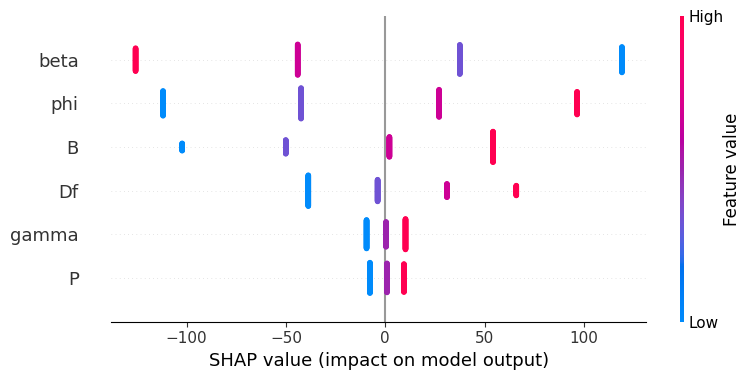

In [ ]:
# Initialize SHAP explainer
r_explainer = shap.Explainer(r_model, X_train)

# Calculate SHAP values
r_shap_values = r_explainer(X_test)

# Get overall SHAP values for each variable
r_shap_df = pd.DataFrame(r_shap_values.values, columns=X.columns)
r_overall_shap = r_shap_df.abs().mean()

print("Overall SHAP Values for Each Feature:")
print(r_overall_shap)

# Summary plot of SHAP values
shap.summary_plot(r_shap_values, X_test)

### **3. Lasso Regression**

Overall SHAP Values for Each Feature:
beta     77.351032
phi      66.535933
B        43.961573
Df       30.988711
gamma     7.016710
P         5.983593
dtype: float64


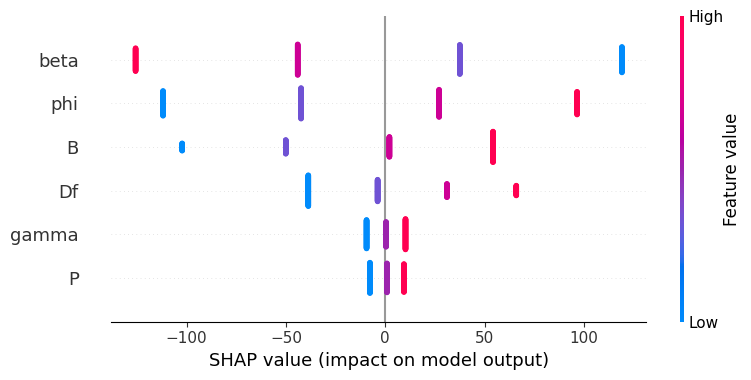

In [ ]:
# Initialize SHAP explainer
l_explainer = shap.Explainer(l_model, X_train)

# Calculate SHAP values
l_shap_values = l_explainer(X_test)

# Get overall SHAP values for each variable
l_shap_df = pd.DataFrame(l_shap_values.values, columns=X.columns)
l_overall_shap = l_shap_df.abs().mean()

print("Overall SHAP Values for Each Feature:")
print(l_overall_shap)

# Summary plot of SHAP values
shap.summary_plot(l_shap_values, X_test)

### **4. Polynomial Regression Regression**

In [ ]:
# Initialize SHAP explainer
p_explainer = shap.Explainer(p_model, Xp_train)

# Compute SHAP values
p_shap_values = p_explainer(Xp_test)

# Get overall SHAP values for each variable
p_shap_df = pd.DataFrame(p_shap_values.values, columns=poly.get_feature_names_out())
p_overall_shap = p_shap_df.abs().mean()

print("Overall SHAP Values for Each Feature:")
print(p_overall_shap)

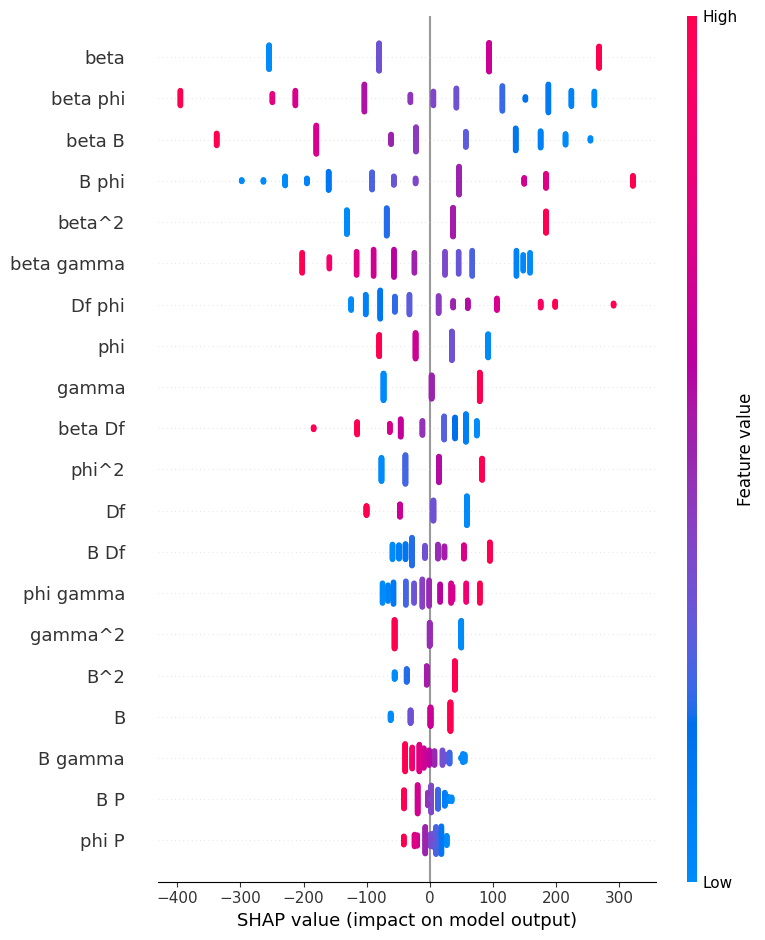

In [ ]:
# Calculate SHAP values
explainer = shap.Explainer(p_model, Xp_train)
shap_values = explainer(Xp_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, features=Xp_test, feature_names=poly.get_feature_names_out(input_features=X.columns))

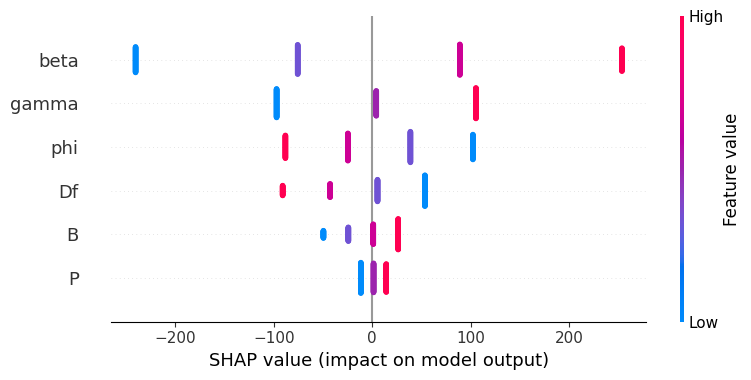

In [ ]:
# Calculate SHAP values
explainer = shap.Explainer(p_model, Xp_train)
shap_values = explainer(Xp_test)

# Convert the feature names for polynomial features
poly_feature_names = poly.get_feature_names_out(input_features=Xp.columns)

# Define the selected features
selected_features = ['beta','B', 'Df', 'phi', 'gamma', 'P']

# Filter SHAP values and test features to include only the selected features
selected_indices = [poly_feature_names.tolist().index(f) for f in selected_features]
shap_values_selected = shap_values[:, selected_indices]
Xp_test_selected = Xp_test[:, selected_indices]

# Plot the SHAP summary plot for the selected features
shap.summary_plot(shap_values_selected.values, features=Xp_test_selected, feature_names=selected_features)

### **5. Support Vector Regression**

  0%|          | 0/259 [00:00<?, ?it/s]

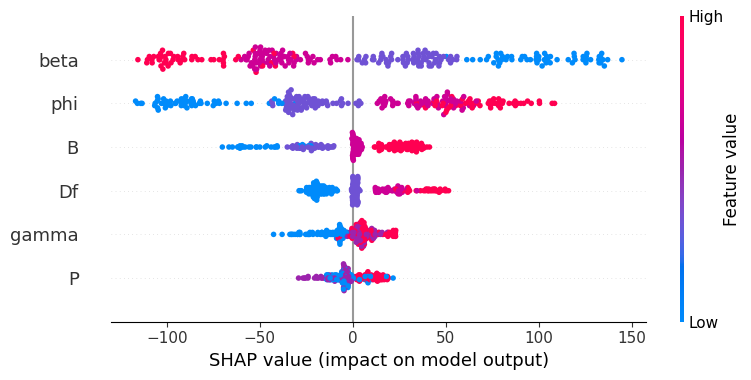

In [ ]:
# Create a SHAP explainer
svr_explainer = shap.KernelExplainer(svr_model.predict, X_train)

# Calculate SHAP values for the test set
svr_shap_values = svr_explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(svr_shap_values, X_test)

In [ ]:
# Create a DataFrame from the SHAP values
svr_shap_df = pd.DataFrame(svr_shap_values, columns=X_test.columns)

# Calculate the mean absolute SHAP value for each feature
svr_mean_shap_values = np.abs(svr_shap_df).mean(axis=0)

# Create a DataFrame to display the results
svr_shap_summary_df = pd.DataFrame(svr_mean_shap_values, columns=["Mean SHAP Value"])

print(svr_shap_summary_df)

       Mean SHAP Value
beta         61.583409
phi          52.451231
B            21.530626
Df           16.680511
gamma         9.732183
P             8.374617


### **6. Decision Tree Regression**

  0%|          | 0/259 [00:00<?, ?it/s]

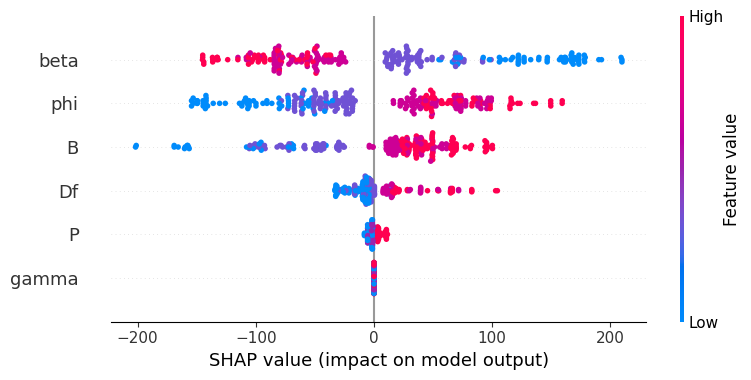

In [ ]:
# Create a SHAP explainer
dt_explainer = shap.KernelExplainer(dt_model.predict, X_train)

# Calculate SHAP values for the test set
dt_shap_values = dt_explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(dt_shap_values, X_test)

In [ ]:
# Create a DataFrame from the SHAP values
dt_shap_df = pd.DataFrame(dt_shap_values, columns=X_test.columns)

# Calculate the mean absolute SHAP value for each feature
dt_mean_shap_values = np.abs(dt_shap_df).mean(axis=0)

# Create a DataFrame to display the results
dt_shap_summary_df = pd.DataFrame(dt_mean_shap_values, columns=["Mean SHAP Value"])

print(dt_shap_summary_df)

       Mean SHAP Value
beta         79.433323
phi          67.546522
B            51.761778
Df           17.448427
P             3.221629
gamma         0.000000


### **7. Random Forest Regression**

  0%|          | 0/259 [00:00<?, ?it/s]

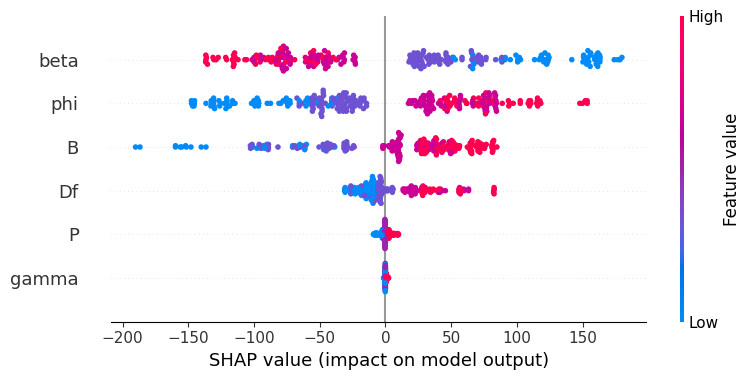

In [ ]:
# Create a SHAP explainer
rf_explainer = shap.KernelExplainer(rf_model.predict, X_train)

# Calculate SHAP values for the test set
rf_shap_values = rf_explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(rf_shap_values, X_test)

In [ ]:
# Create a DataFrame from the SHAP values
rf_shap_df = pd.DataFrame(rf_shap_values, columns=X_test.columns)

# Calculate the mean absolute SHAP value for each feature
rf_mean_shap_values = np.abs(rf_shap_df).mean(axis=0)

# Create a DataFrame to display the results
rf_shap_summary_df = pd.DataFrame(rf_mean_shap_values, columns=["Mean SHAP Value"])

print(rf_shap_summary_df)

       Mean SHAP Value
beta         77.994149
phi          64.819976
B            49.652291
Df           19.152896
P             2.886861
gamma         0.364410


### **8. KNeighbors Regression**

  0%|          | 0/259 [00:00<?, ?it/s]

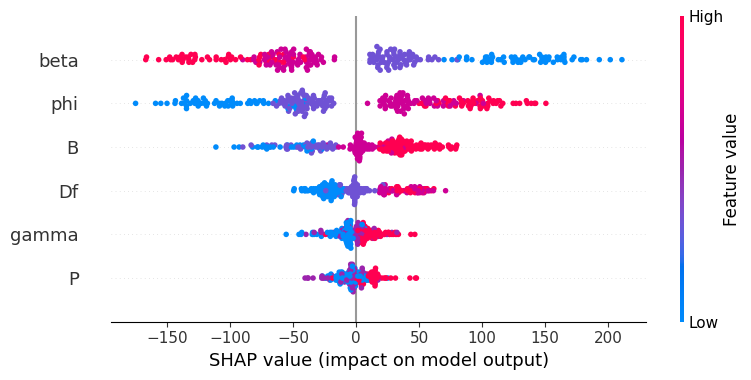

In [ ]:
# Create a SHAP explainer
kn_explainer = shap.KernelExplainer(kn_model.predict, X_train)

# Calculate SHAP values for the test set
kn_shap_values = kn_explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(kn_shap_values, X_test)

In [ ]:
# Create a DataFrame from the SHAP values
kn_shap_df = pd.DataFrame(kn_shap_values, columns=X_test.columns)

# Calculate the mean absolute SHAP value for each feature
kn_mean_shap_values = np.abs(kn_shap_df).mean(axis=0)

# Create a DataFrame to display the results
kn_shap_summary_df = pd.DataFrame(kn_mean_shap_values, columns=["Mean SHAP Value"])

print(kn_shap_summary_df)

       Mean SHAP Value
beta         77.161990
phi          68.658761
B            33.423465
Df           23.518080
gamma        11.244040
P             9.998383


### **9. XGBoost Regression**

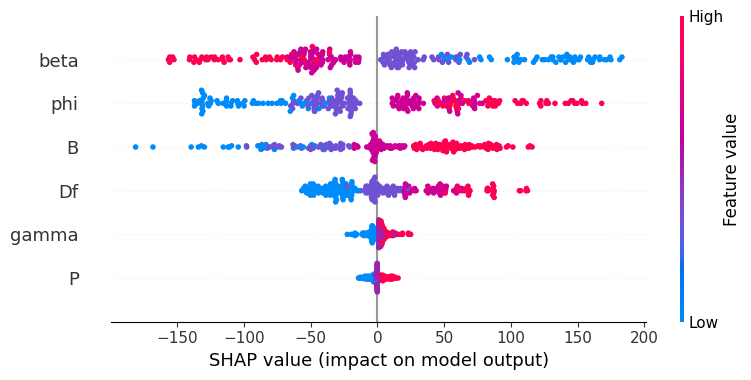

In [ ]:
# Create a SHAP explainer
xgb_explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for the test set
xgb_shap_values = xgb_explainer(X_test)

# Visualize the SHAP values
shap.summary_plot(xgb_shap_values, X_test)

In [ ]:
# Create a DataFrame from the SHAP values
xgb_shap_df = pd.DataFrame(xgb_shap_values.values, columns=X_test.columns)

# Calculate the mean absolute SHAP value for each feature
xgb_mean_shap_values = np.abs(xgb_shap_df).mean(axis=0)

# Create a DataFrame to display the results
xgb_shap_summary_df = pd.DataFrame(xgb_mean_shap_values, columns=["Mean SHAP Value"])

print(xgb_shap_summary_df)

       Mean SHAP Value
beta         69.494812
B            47.348061
Df           33.121319
phi          63.764782
gamma         5.211336
P             4.292779


### **10. Feed Forward Neural Network**

In [ ]:
# Create a SHAP explainer
fnn_explainer = shap.KernelExplainer(fnn_model.predict, X_train)

# Calculate SHAP values for the training set
fnn_shap_values = fnn_explainer.shap_values(X_train)

33/33 [==============================] - 0s 961us/step


  0%|          | 0/1034 [00:00<?, ?it/s]

2004/2004 [==============================] - 2s 1ms/step


In [ ]:
# Convert SHAP values to a NumPy array for easier handling
fnn_shap_values_array = np.array(fnn_shap_values)

# Calculate the mean absolute SHAP values for each feature
fnn_mean_shap_values = np.mean(np.abs(fnn_shap_values_array), axis=0)

# Display the mean SHAP values
feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]
fnn_mean_shap_df = pd.DataFrame(fnn_mean_shap_values, index=feature_names, columns=['Mean SHAP Value'])
print(fnn_mean_shap_df)

           Mean SHAP Value
Feature 0        86.054150
Feature 1        51.825212
Feature 2        30.648195
Feature 3        76.564189
Feature 4         5.350265
Feature 5         5.471679


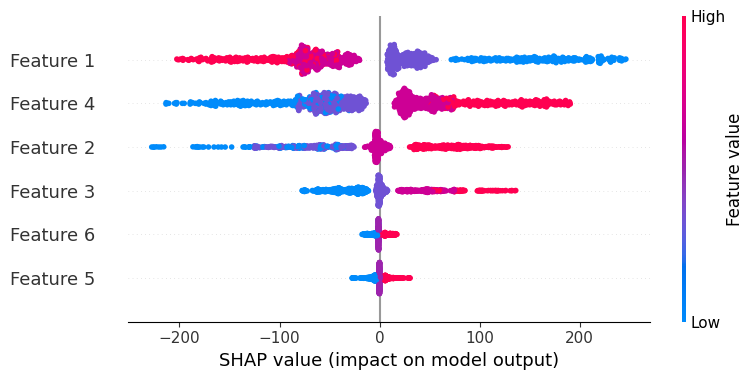

In [ ]:
# Flatten the SHAP values from (n_samples, n_features, 1) to (n_samples, n_features)
shap_values = fnn_shap_values.squeeze(axis=2)

# Define the base values
base_values = np.full((shap_values.shape[0],), 180.46918, dtype=np.float32)

# Assign X_train to the data variable
data = X_train[:shap_values.shape[0]]  # Ensure the number of samples matches

# Create the SHAP values object
shap_values_obj = shap.Explanation(
    values=shap_values,
    base_values=base_values,
    data=data,
    feature_names=[f'Feature {i+1}' for i in range(data.shape[1])]
)

# Generate the summary plot
shap.summary_plot(shap_values_obj)

# **RESULT EXTRACTION**

In [ ]:
# Save the dataframe to csv file
metrics_df.to_csv('/content/drive/MyDrive/Research/Regression Analysis - Qult/Dataset/metrics_output_test_170125.csv', index=False)

# Show metrics dataframe
metrics_df

,Algorithm,RMSE,RSq,MAPE,A20_Index,A30_Index,F1_RMSE,F2_RMSE,F3_RMSE,F4_RMSE,...,F1_A20,F2_A20,F3_A20,F4_A20,F5_A20,F1_A30,F2_A30,F3_A30,F4_A30,F5_A30
1,Ridge,72.840209,0.748188,0.530243,0.366795,0.544402,74.534857,73.841672,78.155536,76.840187,...,0.371981,0.328502,0.371981,0.362319,0.359223,0.531401,0.526570,0.531401,0.507246,0.485437
2,Lasso,72.812879,0.748377,0.530395,0.366795,0.544402,74.553212,73.846855,78.147687,76.850690,...,0.371981,0.328502,0.371981,0.362319,0.359223,0.531401,0.526570,0.531401,0.507246,0.485437
0,Linear,72.812768,0.748378,0.530398,0.366795,0.544402,74.553314,73.846768,78.147618,76.850822,...,0.371981,0.328502,0.371981,0.362319,0.359223,0.531401,0.526570,0.531401,0.507246,0.485437
4,Support Vector,77.104486,0.717841,0.318543,0.505792,0.644788,78.580512,87.203513,86.428058,83.549124,...,0.623188,0.507246,0.555556,0.536232,0.548544,0.724638,0.613527,0.671498,0.724638,0.674757
8,KNeighbors,75.442655,0.729873,0.296892,0.579151,0.675676,81.297243,85.838748,88.316455,83.293867,...,0.642512,0.541063,0.565217,0.570048,0.611650,0.734300,0.676329,0.681159,0.666667,0.684466
5,Decision Tree,55.982792,0.851255,0.238643,0.525097,0.714286,51.123795,59.516834,54.488144,55.079231,...,0.637681,0.487923,0.531401,0.560386,0.538835,0.777778,0.685990,0.729469,0.748792,0.699029
3,Polynomial,27.701391,0.963580,0.199282,0.714286,0.787645,27.168720,29.860393,31.732670,30.083138,...,0.768116,0.695652,0.700483,0.768116,0.679612,0.850242,0.782609,0.768116,0.840580,0.766990
6,Random Forest,46.308278,0.898223,0.204626,0.613900,0.803089,40.418889,54.021106,47.678538,48.596828,...,0.671498,0.536232,0.599034,0.657005,0.635922,0.845411,0.772947,0.821256,0.850242,0.781553
9,Feed Forward NN,23.694488,0.973354,0.131644,0.810811,0.891892,31.336165,29.211182,25.484564,21.763862,...,0.797101,0.787440,0.797101,0.806763,0.815534,0.888889,0.898551,0.903382,0.893720,0.951456
7,XGBoost,19.203387,0.982498,0.083708,0.918919,0.961390,18.732242,20.464591,21.957118,19.683415,...,0.913043,0.937198,0.908213,0.937198,0.922330,0.971014,0.980676,0.980676,0.966184,0.970874


In [ ]:
# Make the dictionary of the outputs
outputs = {
    "y_actual": y_test,
    "y_linear": lr_y_pred,
    "y_ridge": r_y_pred,
    "y_lasso": l_y_pred,
    "y_polynomial": p_y_pred,
    "y_supportvector": svr_y_pred,
    "y_decisiontree": dt_y_pred,
    "y_randomforest": rf_y_pred,
    "y_xgboost": xgb_y_pred,
    "y_kneighbors": kn_y_pred,
    "y_feedforward": fnn_y_pred.flatten()
}

# Turn dictionary into the dataframe
output_df = pd.DataFrame(outputs)

# Save the dataframe to csv file
output_df.to_csv('/content/drive/MyDrive/Research/Regression Analysis - Qult/Dataset/outputs_test_170125.csv', index=False)

#Show the output dataframe
output_df

,y_actual,y_linear,y_ridge,y_lasso,y_polynomial,y_supportvector,y_decisiontree,y_randomforest,y_xgboost,y_kneighbors,y_feedforward
419,51.594,109.051669,109.538412,109.055180,6.710380,139.957629,54.745857,62.522608,57.451698,137.9025,20.652786
560,520.130,380.149629,379.728993,380.144761,532.908436,355.090492,460.369394,440.109361,484.145325,339.7210,513.989075
679,459.890,355.042215,354.695771,355.038512,467.045749,320.800538,460.369394,438.517499,431.966339,468.8345,451.340485
516,91.943,118.668053,118.945816,118.670354,92.798970,116.393868,121.760792,116.551915,108.649620,97.2440,96.189224
315,367.511,331.809326,331.817908,331.809689,374.747068,365.080550,446.885523,440.990380,394.757629,364.8220,391.782318
...,...,...,...,...,...,...,...,...,...,...,...
377,94.760,126.584643,126.435597,126.586802,90.914805,75.983340,105.786541,123.343959,93.722412,83.4640,61.974010
809,51.022,96.914055,97.408363,96.917464,-14.274921,179.197986,71.992776,83.946020,60.542091,202.5005,24.636444
499,131.349,206.220926,205.912651,206.218596,144.687548,117.897014,105.786541,132.197623,129.309662,139.2225,136.902298
10,60.725,190.961522,190.933273,190.962240,132.606160,132.420691,200.985256,135.961482,93.709473,154.0640,148.527802


In [ ]:
# Make the dictionary of the outputs
outputs_train = {
    "y_train_actual": y_train,
    "y_linear": lr_train_pred,
    "y_ridge": r_train_pred,
    "y_lasso": l_train_pred,
    "y_polynomial": p_train_pred,
    "y_supportvector": svr_train_pred,
    "y_decisiontree": dt_train_pred,
    "y_randomforest": rf_train_pred,
    "y_xgboost": xgb_train_pred,
    "y_kneighbors": kn_train_pred,
    "y_feedforward": fnn_train_pred.flatten()
}

# Turn dictionary into the dataframe
output_train_df = pd.DataFrame(outputs_train)

# Save the dataframe to csv file
output_train_df.to_csv('/content/drive/MyDrive/Research/Regression Analysis - Qult/Dataset/outputs_train_170125.csv', index=False)

#Show the output dataframe
output_train_df

,y_train_actual,y_linear,y_ridge,y_lasso,y_polynomial,y_supportvector,y_decisiontree,y_randomforest,y_xgboost,y_kneighbors,y_feedforward
1153,107.550,128.523140,128.457462,128.521920,110.445383,121.103222,154.648783,144.982315,109.408218,88.8950,101.031128
1052,58.649,168.710728,168.974359,168.712029,87.583538,231.870303,71.992776,83.946020,60.542091,225.1090,87.865524
889,139.741,194.083312,193.782602,194.080879,156.388117,139.640806,62.019913,78.773466,130.947327,158.4110,138.044464
407,198.265,196.091711,195.925389,196.093544,187.796915,192.348926,207.347226,222.540187,186.915894,209.5790,166.086456
753,52.510,44.996854,45.224461,44.998362,41.998525,70.645961,62.019913,57.678973,66.407707,58.1285,40.678780
...,...,...,...,...,...,...,...,...,...,...,...
1130,56.832,137.546043,137.195984,137.542670,89.684174,56.932138,68.143563,91.814935,62.939873,50.7035,59.698509
1181,78.087,128.201077,128.273737,128.203300,80.852406,94.357314,137.238600,111.767885,72.705788,89.0945,73.451828
1246,86.078,77.390188,77.338575,77.388500,73.543347,85.056643,88.862558,86.743942,79.384651,86.0780,86.697083
946,316.611,298.049009,297.938000,298.046444,303.135471,313.976562,313.348833,311.123718,306.569214,289.0220,314.121521


In [ ]:
# Make the dictionary of the outputs
shap = {
    "Algorithm": ['Linear','Ridge','Lasso','Polynomial','Support Vector','Decision Tree','Random Forest','XGBoost','KNeigbour','Feed Forward NN'],
    "beta": [lr_overall_shap.loc['beta'],r_overall_shap.loc['beta'],l_overall_shap.loc['beta'],p_overall_shap.loc['beta'],svr_shap_summary_df.loc['beta'].values[0],dt_shap_summary_df.loc['beta'].values[0],rf_shap_summary_df.loc['beta'].values[0],xgb_shap_summary_df.loc['beta'].values[0],kn_shap_summary_df.loc['beta'].values[0],fnn_mean_shap_df.loc['Feature 0'].values[0]],
    "B": [lr_overall_shap.loc['B'],r_overall_shap.loc['B'],l_overall_shap.loc['B'],p_overall_shap.loc['B'],svr_shap_summary_df.loc['B'].values[0],dt_shap_summary_df.loc['B'].values[0],rf_shap_summary_df.loc['B'].values[0],xgb_shap_summary_df.loc['B'].values[0],kn_shap_summary_df.loc['B'].values[0],fnn_mean_shap_df.loc['Feature 1'].values[0]],
    "Df": [lr_overall_shap.loc['Df'],r_overall_shap.loc['Df'],l_overall_shap.loc['Df'],p_overall_shap.loc['Df'],svr_shap_summary_df.loc['Df'].values[0],dt_shap_summary_df.loc['Df'].values[0],rf_shap_summary_df.loc['Df'].values[0],xgb_shap_summary_df.loc['Df'].values[0],kn_shap_summary_df.loc['Df'].values[0],fnn_mean_shap_df.loc['Feature 2'].values[0]],
    "phi": [lr_overall_shap.loc['phi'],r_overall_shap.loc['phi'],l_overall_shap.loc['phi'],p_overall_shap.loc['phi'],svr_shap_summary_df.loc['phi'].values[0],dt_shap_summary_df.loc['phi'].values[0],rf_shap_summary_df.loc['phi'].values[0],xgb_shap_summary_df.loc['phi'].values[0],kn_shap_summary_df.loc['phi'].values[0],fnn_mean_shap_df.loc['Feature 3'].values[0]],
    "gamma": [lr_overall_shap.loc['gamma'],r_overall_shap.loc['gamma'],l_overall_shap.loc['gamma'],p_overall_shap.loc['gamma'],svr_shap_summary_df.loc['gamma'].values[0],dt_shap_summary_df.loc['gamma'].values[0],rf_shap_summary_df.loc['gamma'].values[0],xgb_shap_summary_df.loc['gamma'].values[0],kn_shap_summary_df.loc['gamma'].values[0],fnn_mean_shap_df.loc['Feature 4'].values[0]],
    "P": [lr_overall_shap.loc['P'],r_overall_shap.loc['P'],l_overall_shap.loc['P'],p_overall_shap.loc['P'],svr_shap_summary_df.loc['P'].values[0],dt_shap_summary_df.loc['P'].values[0],rf_shap_summary_df.loc['P'].values[0],xgb_shap_summary_df.loc['P'].values[0],kn_shap_summary_df.loc['P'].values[0],fnn_mean_shap_df.loc['Feature 5'].values[0]],
}

# Turn dictionary into the dataframe
shap_df = pd.DataFrame(shap)

# Save the dataframe to csv file
shap_df.to_csv('/content/drive/MyDrive/Research/Regression Analysis - q/Dataset/SHAP.csv', index=False)

#Show the output dataframe
shap_df

,Algorithm,beta,B,Df,phi,gamma,P
0,Linear,77.351245,43.962136,30.990384,66.536245,7.017225,5.983645
1,Ridge,77.351221,43.961947,30.990316,66.536229,7.017223,5.983645
2,Lasso,77.351032,43.961573,30.988711,66.535933,7.016710,5.983593
3,Polynomial,165.156938,26.605896,47.050034,55.071435,54.545412,10.811318
4,Support Vector,61.583409,21.530626,16.680511,52.451231,9.732183,8.374617
5,Decision Tree,79.433323,51.761778,17.448427,67.546522,0.000000,3.221629
6,Random Forest,77.994149,49.652291,19.152896,64.819976,0.364410,2.886861
7,XGBoost,69.494812,47.348061,33.121319,63.764782,5.211336,4.292779
8,KNeigbour,77.161990,33.423465,23.518080,68.658761,11.244040,9.998383
9,Feed Forward NN,86.054150,51.825212,30.648195,76.564189,5.350265,5.471679
